# Quantum Support Vector Classifier

The software is implemented using qiskit-1.0.0 stable version.
Please be sure to have installed the last version of qiskit and spin-off libraries, such as qiskit_algorithms and qiskit_machine_learning
If this is not the case, it might be convenient to create a new conda environment with the new versions of the software.
Be sure to have also updated the sinoff libraries. To update the libraries do:
- pip install -U qiskit_algorithms
- pip install -U qiskit_machine_learning
- pip install qiskit_ibm_runtime

### Import the dataset and select the features

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, balanced_accuracy_score

from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap, RealAmplitudes
from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA, SPSA, ADAM, QNSPSA, GradientDescent
from qiskit.primitives import Sampler, Estimator
from qiskit_machine_learning.algorithms import QSVC, PegasosQSVC
from qiskit.quantum_info import Statevector
from qiskit.visualization import circuit_drawer
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit import ParameterVector
from qiskit.providers import Options

from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer

import qiskit_ibm_runtime as IBMR
from qiskit_ibm_provider import IBMProvider

from IPython.display import clear_output

import matplotlib

import random

In [2]:
# set the seed (for testing purposes)
algorithm_globals.random_seed = 42
random.seed(42)

In [3]:
file_path = "dataset/dataset.csv"

try:
    df = pd.read_csv(file_path)
    print("Dataset imported successfully.")
except FileNotFoundError:
    print("File not found. Please check the file path.")
    exit()

Dataset imported successfully.


Feature selection (according to the results obtained in the previous feature analysis)

In [4]:
df.drop(columns=['step'], inplace=True)
df.drop(columns=['zipcodeOri'], inplace=True)
df.drop(columns=['zipMerchant'], inplace=True)
df.drop(columns=['customer'], inplace=True)
df.drop(columns=['merchant'], inplace=True)

encoder = LabelEncoder()

encoded_age = encoder.fit_transform(df['age'])
df['age'] = encoded_age
encoded_gender = encoder.fit_transform(df['gender'])
df['gender'] = encoded_gender
encoded_category = encoder.fit_transform(df['category'])
df['category'] = encoded_category

print(df.head())

   age  gender  category  amount  fraud
0    4       2        12    4.55      0
1    2       2        12   39.68      0
2    4       1        12   26.89      0
3    3       2        12   17.25      0
4    5       2        12   35.72      0


Undersampling (random undersampling)

In [5]:
X = df.drop('fraud', axis=1)
y = df['fraud']

# Check class distribution
print("Class distribution before undersampling:")
print(y.value_counts())

sampling_strategy = {0: 100, 1: 100}

# Undersample the majority class
undersample = RandomUnderSampler(sampling_strategy = sampling_strategy, random_state = 42)
X_resampled, y_resampled = undersample.fit_resample(X, y)

# Check class distribution after undersampling
print("Class distribution after undersampling:")
print(pd.Series(y_resampled).value_counts())

Class distribution before undersampling:
fraud
0    587443
1      7200
Name: count, dtype: int64
Class distribution after undersampling:
fraud
0    100
1    100
Name: count, dtype: int64


Create train and test datasets with the undersampled dataset

In [6]:
# Transform all the features in the interval [0, 1]
X_resampled = MinMaxScaler().fit_transform(X_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

(140, 4) (60, 4)


write a function to display the models' results

In [7]:
def evaluate_with_feature_map(model, X_train, y_train, X_test, y_test, feature_map_name):
    # Perform predictions on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Print classification report and confusion matrix for training set
    print(f"Classification Report for {feature_map_name} Feature Map (Train Set):\n")
    print(classification_report(y_train, y_train_pred))
    print("Confusion Matrix for Train Set:")
    print(confusion_matrix(y_train, y_train_pred))
    print("\n")
    
    # Print classification report and confusion matrix for test set
    print(f"Classification Report for {feature_map_name} Feature Map (Test Set):\n")
    print(classification_report(y_test, y_test_pred))
    print("Confusion Matrix for Test Set:")
    print(confusion_matrix(y_test, y_test_pred))
    
    # Print ROC AUC score for test set
    print(f"ROC AUC Score for {feature_map_name} Feature Map (Test Set):")
    print(round(roc_auc_score(y_test, y_test_pred), 4))
    print(70*'=')

In [227]:
def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    # A train plot
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker = marker,
        facecolors = face,
        edgecolors = edge,
        label = label,
    )

def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation = "nearest",
        origin = "lower",
        cmap = "RdBu",
        extent = [0, 2 * np.pi, 0, 2 * np.pi],
    )

### Implement a Support Vector Classifier with a Quantum Kernel by hand

- Implement a function that takes two data points as input and returns the kernel value
- compute the kernel matrix
- Build a support vector machine using the calculated quantum kernel matrix
- Train the SVC (import from sklearn for example) on these data points and test the prediction.

Encode the classical data into quantum data via 5 different feature maps:

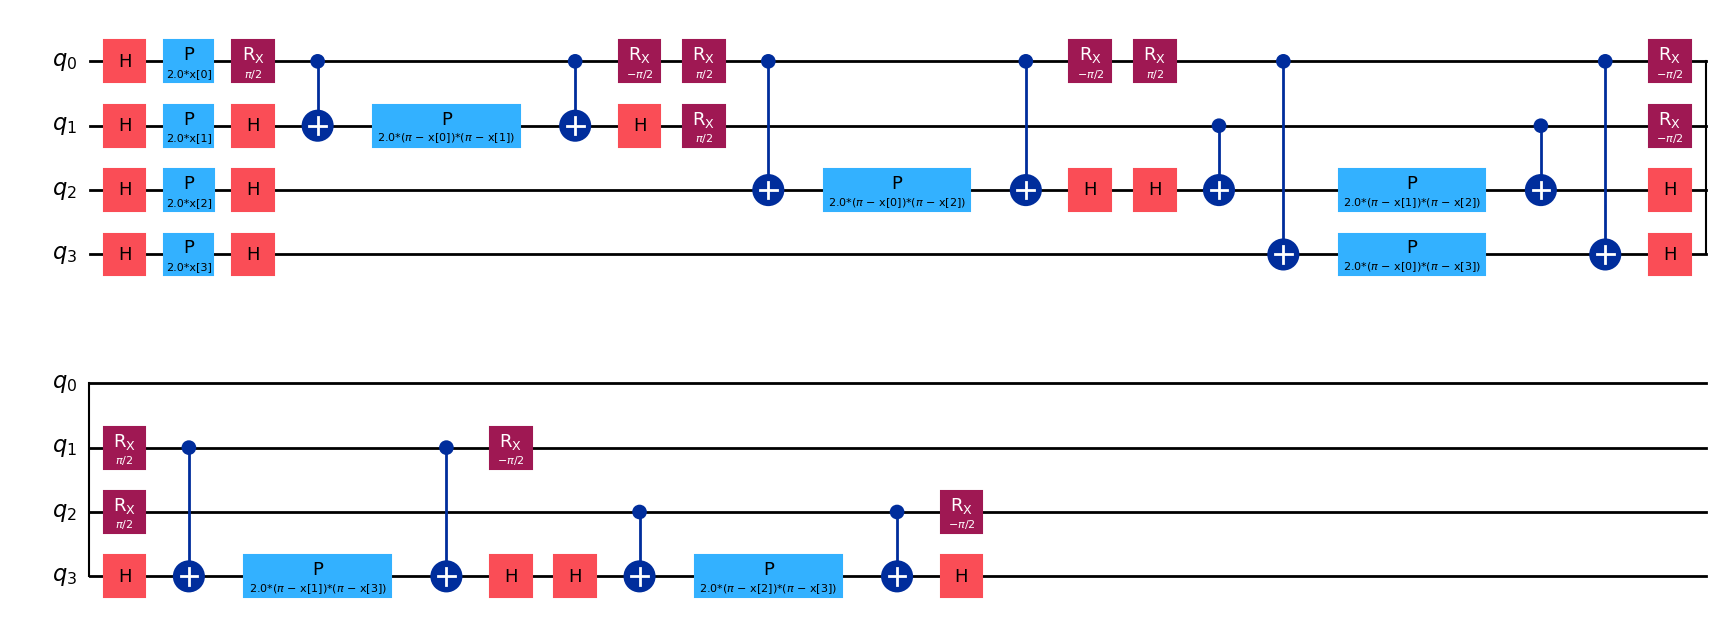

In [8]:
num_features = X.shape[1]

# feature_dimension = num_features
Z = ZFeatureMap(feature_dimension = num_features, reps = 1)
ZZ = ZZFeatureMap(feature_dimension = num_features, reps = 1)
P = PauliFeatureMap(feature_dimension = num_features, reps = 1, paulis = ['Z', 'XY'])
Z2 = ZFeatureMap(feature_dimension = num_features, reps = 2)
ZZ2 = ZZFeatureMap(feature_dimension = num_features, reps = 2)

# dictionary for the feature maps' names
feature_map_dict = {'Z': Z, 'ZZ': ZZ, 'Pauli(Z, XY)': P, 'Z with 2 layers': Z2, 'ZZ with 2 layers': ZZ2}

#ZZ.decompose().draw(output='mpl')
#Z.decompose().draw(output='mpl')
P.decompose().draw(output='mpl')
#ZZ2.decompose().draw(output='mpl')
#Z2.decompose().draw(output='mpl')

Create a custom function to compute the qunatum kernel

In [9]:
# import the sampler primitive as specified by the qiskit-1.0.0 standard
sampler = Sampler()
def quantum_kernel(x1, x2, FeatureMap, shots = 10):
    assert len(x1) == len(x2)
    n = len(x1)
    encoded_x_i = FeatureMap.assign_parameters(x1)
    encoded_x_j = FeatureMap.assign_parameters(x2)
    qc = QuantumCircuit(n, n)
    qc.append(encoded_x_i, range(n))
    qc.append(encoded_x_j.inverse(), range(n))
    qc.measure(range(n), range(n))
    # commented lines for qiskit < 1.0.0:
    #backend = Aer.get_backend('qasm_simulator')
    #result = execute(qc, backend, shots=shots).result()
    #counts = result.get_counts()
    #kernel_value = counts.get('0' * n, 0) / shots
    result = sampler.run(qc, shots = shots).result()
    counts = result.quasi_dists[0]
    kernel_value = counts.get(0, 0)
    #print(res, counts, kernel_value)
    return kernel_value

fit the model on actual dataset:

In [10]:
if False:
    # Compute the train kernel matrix
    K_train = np.array([[quantum_kernel(X_train[i], X_train[j], ZZ) for j in range(len(X_train))] for i in range(len(X_train))])
    # Train the SVM
    qsvm = svm.SVC(kernel = 'precomputed')
    qsvm.fit(K_train, y_train)
    # Predict and compute the test kernel matrix
    K_test = np.array([[quantum_kernel(X_test[i], X_test[j], ZZ) for j in range(len(X_test))] for i in range(len(X_test))])
    y_train_pred = qsvm.predict(K_train)
    y_test_pred  = qsvm.predict(K_test)
    # print the model report
    print(classification_report(y_train, y_train_pred))
    print("Confusion Matrix for Train Set:")    
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_test, y_test_pred))
    print("Confusion Matrix for Test Set:")
    print(confusion_matrix(y_test, y_test_pred))
    print(f"ROC AUC Score (Test Set):")
    print(round(roc_auc_score(y_test, y_test_pred),2))

### Build a Support Vector Classifier with the Fidelity Quantum Kernel (qiskit), precomputing the quantum kernel matrix

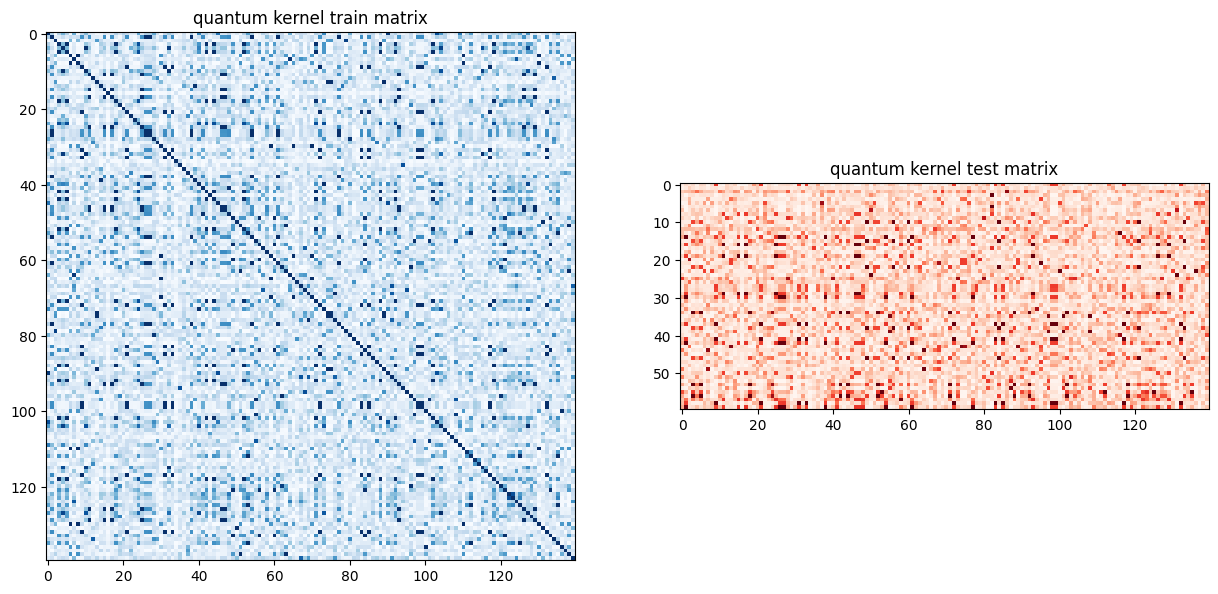

In [11]:
sampler = Sampler()
fidelity = ComputeUncompute(sampler = sampler)
quantum_kernel = FidelityQuantumKernel(fidelity = fidelity, feature_map = ZZ)

kernel_matrix_train = quantum_kernel.evaluate(x_vec = X_train)
kernel_matrix_test  = quantum_kernel.evaluate(x_vec = X_test, y_vec = X_train)

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow( np.asmatrix(kernel_matrix_train), interpolation = "nearest", origin = "upper", cmap = "Blues")
plt.title("quantum kernel train matrix")
plt.subplot(122)
plt.imshow(np.asmatrix(kernel_matrix_test), interpolation = "nearest", origin = "upper", cmap = "Reds")
plt.title("quantum kernel test matrix")

plt.show()

In [12]:
svc = svm.SVC(kernel = "precomputed")
svc.fit(kernel_matrix_train, y_train.values)
print(f"Evaluating performance for ZZ Feature Map:\n")
#evaluate_with_feature_map(svc, X_train, y_train.values, X_test, y_test.values, 'ZZ')
svc_score = svc.score(kernel_matrix_test, y_test.values)
print(f"Precomputed kernel classification test score: {svc_score}")

Evaluating performance for ZZ Feature Map:

Precomputed kernel classification test score: 0.9166666666666666


Build a Support Vector Classifier with a Quantum Kernel using directly the qiskit method QSVC (this is an extension of the sklearn method SVC)

In [13]:
sampler = Sampler()
fidelity = ComputeUncompute(sampler = sampler)

for feature_map_name, feature_map in feature_map_dict.items():
    quantum_kernel = FidelityQuantumKernel(fidelity = fidelity, feature_map = feature_map)
    qsvc = QSVC(quantum_kernel = quantum_kernel)
    qsvc.fit(X_train, y_train.values)
    #qsvc_score = qsvc.score(X_test, y_test.values)
    #print(f"QSVC classification test score: {qsvc_score}")
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    # Perform predictions and evaluate performance metrics
    evaluate_with_feature_map(qsvc, X_train, y_train.values, X_test, y_test.values, feature_map_name)

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        71
           1       0.88      0.81      0.84        69

    accuracy                           0.85       140
   macro avg       0.85      0.85      0.85       140
weighted avg       0.85      0.85      0.85       140

Confusion Matrix for Train Set:
[[63  8]
 [13 56]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.87      0.89        31

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60

Confusion Matrix for Test Set:
[[26  3]
 [ 4 27]]
ROC AUC Score for Z Feature Map (Test Set):
0.8838
Evaluating performance for ZZ Feature Map:

We can see that we obtain the same result as before for for all the feature maps.

### Use Trainable Quantum Kernels with parametrized feature maps

In this case we can also follow the training process of the quantum kernels with a callback function.
Then, once obtained the optimal kernel, we can fit the quantum SVC with that kernel.

In [99]:
# set up some callback functions

class QKTCallback:

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1 = None, x2 = None, x3 = None, x4 = None):
        """
        Args (from the qiskit documentation):
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

In [103]:
# create the feature maps
Z = ZFeatureMap(feature_dimension = num_features, reps = 1)
ZZ = ZZFeatureMap(feature_dimension = num_features, reps = 1)
P = PauliFeatureMap(feature_dimension = num_features, reps = 1, paulis = ['Z', 'XY'])
Z2 = ZFeatureMap(feature_dimension = num_features, reps = 2)
ZZ2 = ZZFeatureMap(feature_dimension = num_features, reps = 2)

# Create a parametrized layer to train. We can rotate each qubit the same amount, or different amount.
training_params = ParameterVector("θ", 1)
#training_params = ParameterVector("θ", num_features)
ansatz_layer = QuantumCircuit(num_features)
for i in range(num_features):
    ansatz_layer.ry(training_params[0], i)

# Create the trainable feature maps, composed of two circuits: the ansatz and the previous feature map
Z_param   = ansatz_layer.compose(Z)
ZZ_param  = ansatz_layer.compose(ZZ)
P_param   = ansatz_layer.compose(P)
Z2_param  = ansatz_layer.compose(Z2)
ZZ2_param = ansatz_layer.compose(ZZ2)

parametric_feature_map_dict = {'Z': Z_param, 'ZZ': ZZ_param, 'Pauli(Z, XY)': P_param, 'Z with 2 layers': Z2_param, 'ZZ with 2 layers': ZZ2_param}

print(circuit_drawer(ZZ_param))
print(f"Trainable parameters: {training_params}")

     ┌──────────┐┌────────────────────────────────────┐
q_0: ┤ Ry(θ[0]) ├┤0                                   ├
     ├──────────┤│                                    │
q_1: ┤ Ry(θ[0]) ├┤1                                   ├
     ├──────────┤│  ZZFeatureMap(x[0],x[1],x[2],x[3]) │
q_2: ┤ Ry(θ[0]) ├┤2                                   ├
     ├──────────┤│                                    │
q_3: ┤ Ry(θ[0]) ├┤3                                   ├
     └──────────┘└────────────────────────────────────┘
Trainable parameters: θ, ['θ[0]']


In [16]:
# Instantiate the trainable quantum kernel form qiskit library
sampler = Sampler()
fidelity = ComputeUncompute(sampler = sampler)
quantum_kernel = TrainableFidelityQuantumKernel(fidelity = fidelity, feature_map = ZZ2_param, training_parameters = training_params)

# Set up the optimizer
qkt_callback = QKTCallback()
optimizer = SPSA(maxiter = 20, callback = qkt_callback.callback, learning_rate = 0.05, perturbation = 0.05)
#optimizer = COBYLA(maxiter = 20)

# Instantiate a quantum kernel trainer
qkt = QuantumKernelTrainer(quantum_kernel = quantum_kernel, loss = "svc_loss", optimizer = optimizer, initial_point = [np.pi / 2])

# Train the kernel using QKT directly
qkt_results = qkt.fit(X_train, y_train)
optimized_kernel = qkt_results.quantum_kernel
print(qkt_results)

{   'optimal_circuit': None,
    'optimal_parameters': {ParameterVectorElement(θ[0]): 2.3166635460720943},
    'optimal_point': array([2.31666355]),
    'optimal_value': 35.50573965848396,
    'optimizer_evals': 60,
    'optimizer_result': None,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x7fbdc8ac8430>}


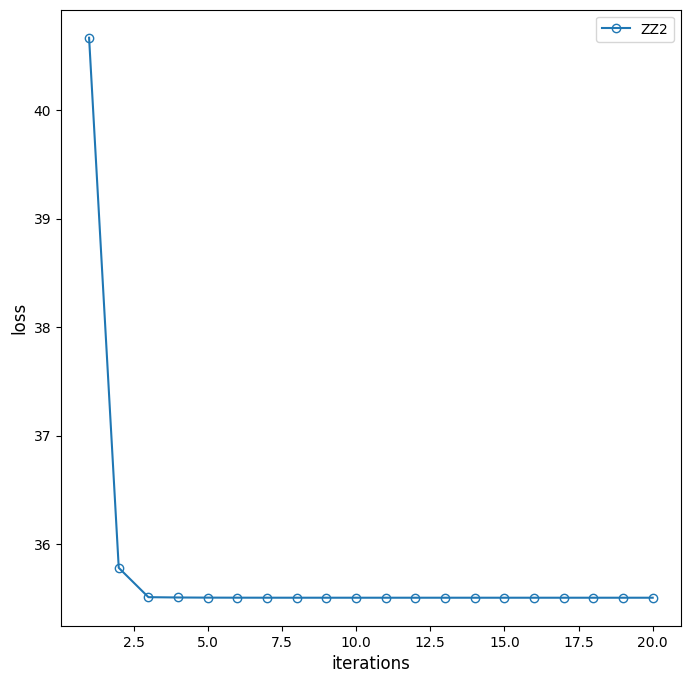

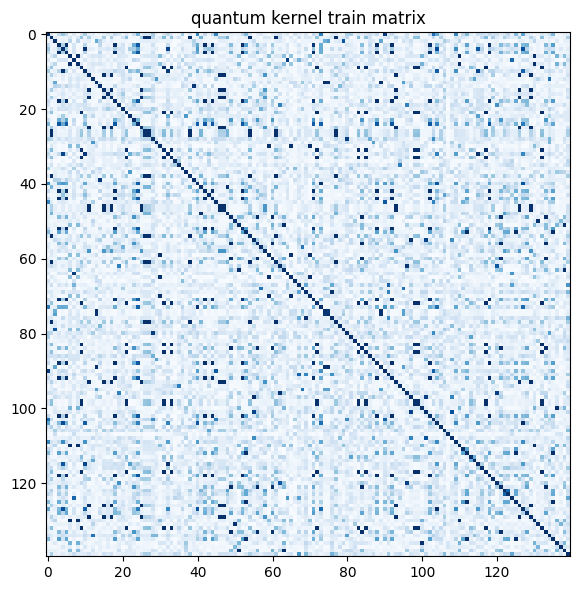

In [17]:
# visualize the training process of the quantum kernel
plot_data = qkt_callback.get_callback_data()
# compute kernel matrix evaluated on the training samples
optimized_kernel_matrix_train = optimized_kernel.evaluate(X_train)

#matplotlib.rcdefaults() 
fig = plt.figure(figsize=(8,8))
plt.plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), marker = 'o', mfc = 'none', label = 'ZZ2')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.show()

fig = plt.figure(figsize=(6,6))
plt.title("quantum kernel train matrix")
plt.imshow(optimized_kernel_matrix_train, interpolation = "nearest", origin = "upper", cmap = "Blues")
fig.tight_layout()
plt.show()

In [18]:
# pass the trained quantum kernel to a machine learning model, then fit the model and test on new data
qsvc = QSVC(quantum_kernel = optimized_kernel)
# Fit the QSVC
qsvc.fit(X_train, y_train)
print(f"Evaluating performance for ZZ with 2 layers Feature Map:\n")
evaluate_with_feature_map(qsvc, X_train, y_train.values, X_test, y_test.values, 'ZZ with 2 layers')

# Predict the labels
y_test_pred = qsvc.predict(X_test)
# Evalaute the test accuracy
accuracy_test = balanced_accuracy_score(y_true = y_test, y_pred = y_test_pred)
print(f"QSVC accuracy test: {accuracy_test}")
qsvc_score = qsvc.score(X_test, y_test.values)
print(f"QSVC classification test score: {qsvc_score}")

Evaluating performance for ZZ with 2 layers Feature Map:

Classification Report for ZZ with 2 layers Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.99      0.94      0.96        71
           1       0.94      0.99      0.96        69

    accuracy                           0.96       140
   macro avg       0.96      0.96      0.96       140
weighted avg       0.97      0.96      0.96       140

Confusion Matrix for Train Set:
[[67  4]
 [ 1 68]]


Classification Report for ZZ with 2 layers Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.87      0.89        31

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60

Confusion Matrix for Test Set:
[[26  3]
 [ 4 27]]
ROC AUC Score for ZZ with 2 layers Feature Map (

fit the model with all the other feature maps

In [104]:
# run on ibm quntum, import the Sampler class from IBM Qiskit Runtime
#service = IBMR.QiskitRuntimeService()#channel = "ibm_quantum")
#backend = service.get_backend("ibmq_qasm_simulator")
# Set options to (eventually to include noise models)
#options = IBMR.Options()
#options.execution.shots = 1000
#options.optimization_level = 3
#options.resilience_level = 0
#sampler = IBMR.Sampler(backend = backend)

# local run: instantiate the Sampler class from qiskit
sampler = Sampler()
fidelity = ComputeUncompute(sampler = sampler)

optimized_kernels = {}
callback_data = []
qkt_callback = QKTCallback()
optimizer = SPSA(maxiter = 20, callback = qkt_callback.callback, learning_rate = 0.05, perturbation = 0.05)
#optimizer = COBYLA(maxiter = 20)

for feature_map_name, feature_map in parametric_feature_map_dict.items():
    quantum_kernel = TrainableFidelityQuantumKernel(fidelity = fidelity, feature_map = feature_map, training_parameters = training_params)
    qkt = QuantumKernelTrainer(quantum_kernel = quantum_kernel, loss = "svc_loss", optimizer = optimizer, initial_point = [np.pi / 2])
    # Train the kernel
    qkt_results = qkt.fit(X_train, y_train)
    optimized_kernels[feature_map_name] = qkt_results.quantum_kernel
    #optimized_kernels.append(optimized_kernel)
    callback_data.append(qkt_callback.get_callback_data())
    qkt_callback.clear_callback_data()

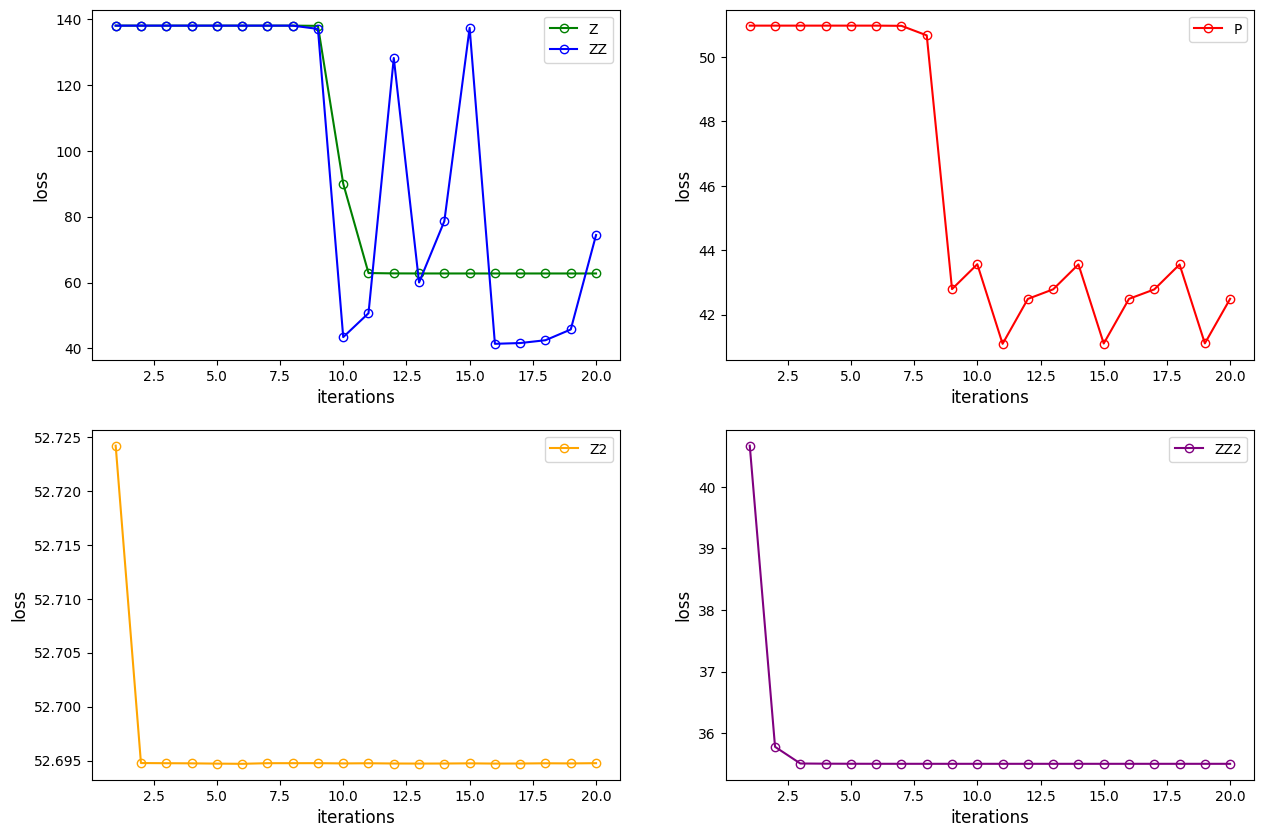

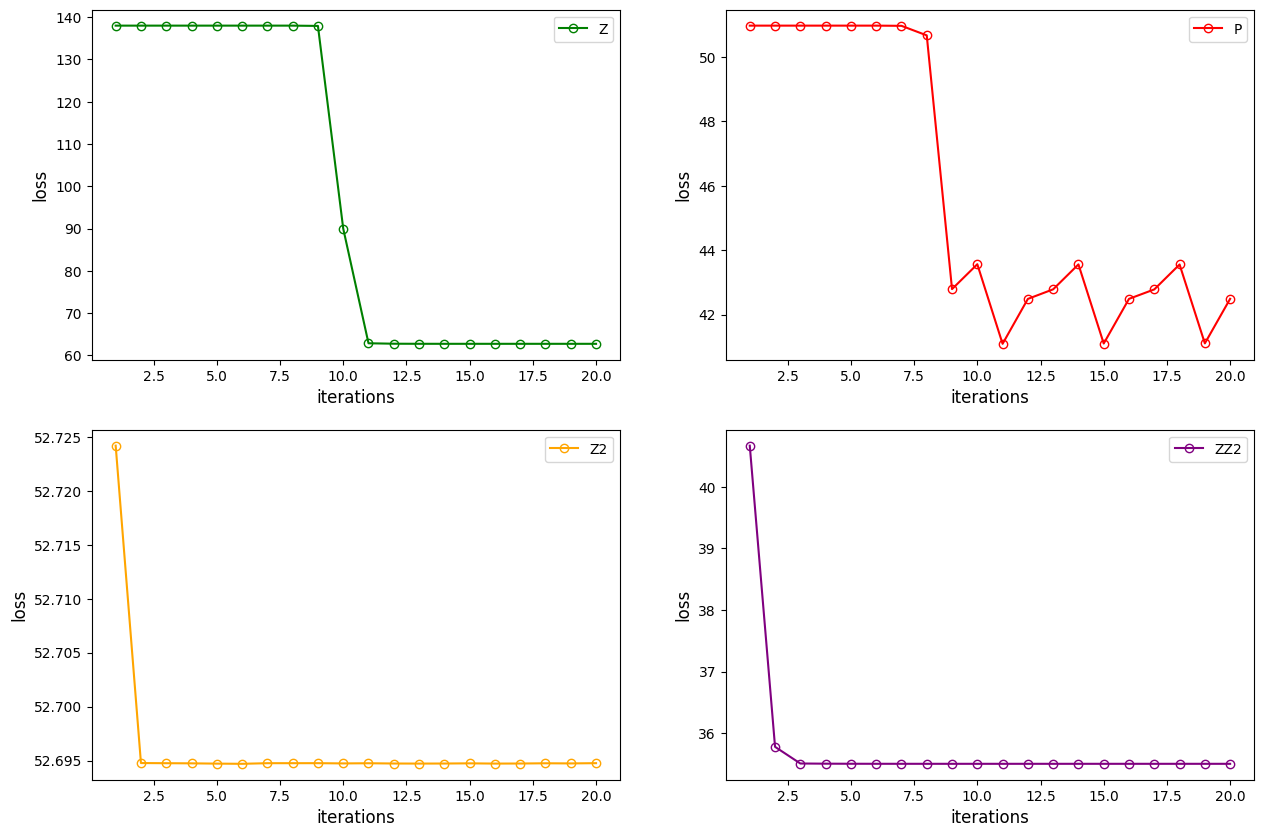

In [109]:
# visualize the training process for all the feature maps

#matplotlib.rcdefaults() 
fig = plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot([i + 1 for i in range(len(callback_data[0][0]))], np.array(callback_data[0][2]), marker = 'o', mfc = 'none', color = 'green', label = 'Z')
plt.plot([i + 1 for i in range(len(callback_data[1][0]))], np.array(callback_data[1][2]), marker = 'o', mfc = 'none', color = 'blue', label = 'ZZ')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(222)
plt.plot([i + 1 for i in range(len(callback_data[2][0]))], np.array(callback_data[2][2]), marker = 'o', mfc = 'none', color = 'red', label = 'P')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(223)
plt.plot([i + 1 for i in range(len(callback_data[3][0]))], np.array(callback_data[3][2]), marker = 'o', mfc = 'none', color = 'orange', label = 'Z2')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(224)
plt.plot([i + 1 for i in range(len(callback_data[4][0]))], np.array(callback_data[4][2]), marker = 'o', mfc = 'none', color = 'purple', label = 'ZZ2')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot([i + 1 for i in range(len(callback_data[0][0]))], np.array(callback_data[0][2]), marker = 'o', mfc = 'none', color = 'green', label = 'Z')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(222)
plt.plot([i + 1 for i in range(len(callback_data[2][0]))], np.array(callback_data[2][2]), marker = 'o', mfc = 'none', color = 'red', label = 'P')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(223)
plt.plot([i + 1 for i in range(len(callback_data[3][0]))], np.array(callback_data[3][2]), marker = 'o', mfc = 'none', color = 'orange', label = 'Z2')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(224)
plt.plot([i + 1 for i in range(len(callback_data[4][0]))], np.array(callback_data[4][2]), marker = 'o', mfc = 'none', color = 'purple', label = 'ZZ2')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.show()

In [108]:
for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train.values)
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    # Perform predictions and evaluate performance metrics
    evaluate_with_feature_map(qsvc, X_train, y_train.values, X_test, y_test.values, feature_map_name)

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        71
           1       0.88      0.81      0.84        69

    accuracy                           0.85       140
   macro avg       0.85      0.85      0.85       140
weighted avg       0.85      0.85      0.85       140

Confusion Matrix for Train Set:
[[63  8]
 [13 56]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.87      0.89        31

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60

Confusion Matrix for Test Set:
[[26  3]
 [ 4 27]]
ROC AUC Score for Z Feature Map (Test Set):
0.8838
Evaluating performance for ZZ Feature Map:

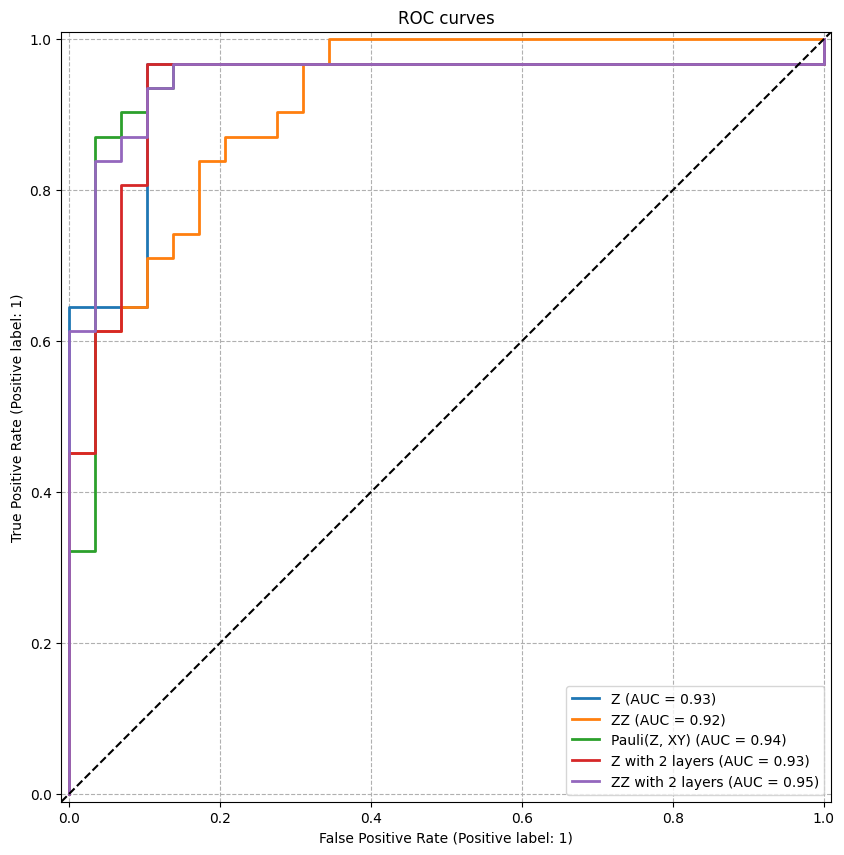

In [106]:
from sklearn.metrics import roc_curve, roc_auc_score, DetCurveDisplay, RocCurveDisplay

fig, ax_roc = plt.subplots(1, 1, figsize = (10, 10))

for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train.values)
    RocCurveDisplay.from_estimator(qsvc, X_test, y_test.values, ax = ax_roc, name = feature_map_name, lw = 2)

ax_roc.set_title("ROC curves")
ax_roc.grid(linestyle = "--")
ax_roc.axline((0, 0), slope = 1, color = 'k', linestyle = '--')

plt.legend()
plt.show()

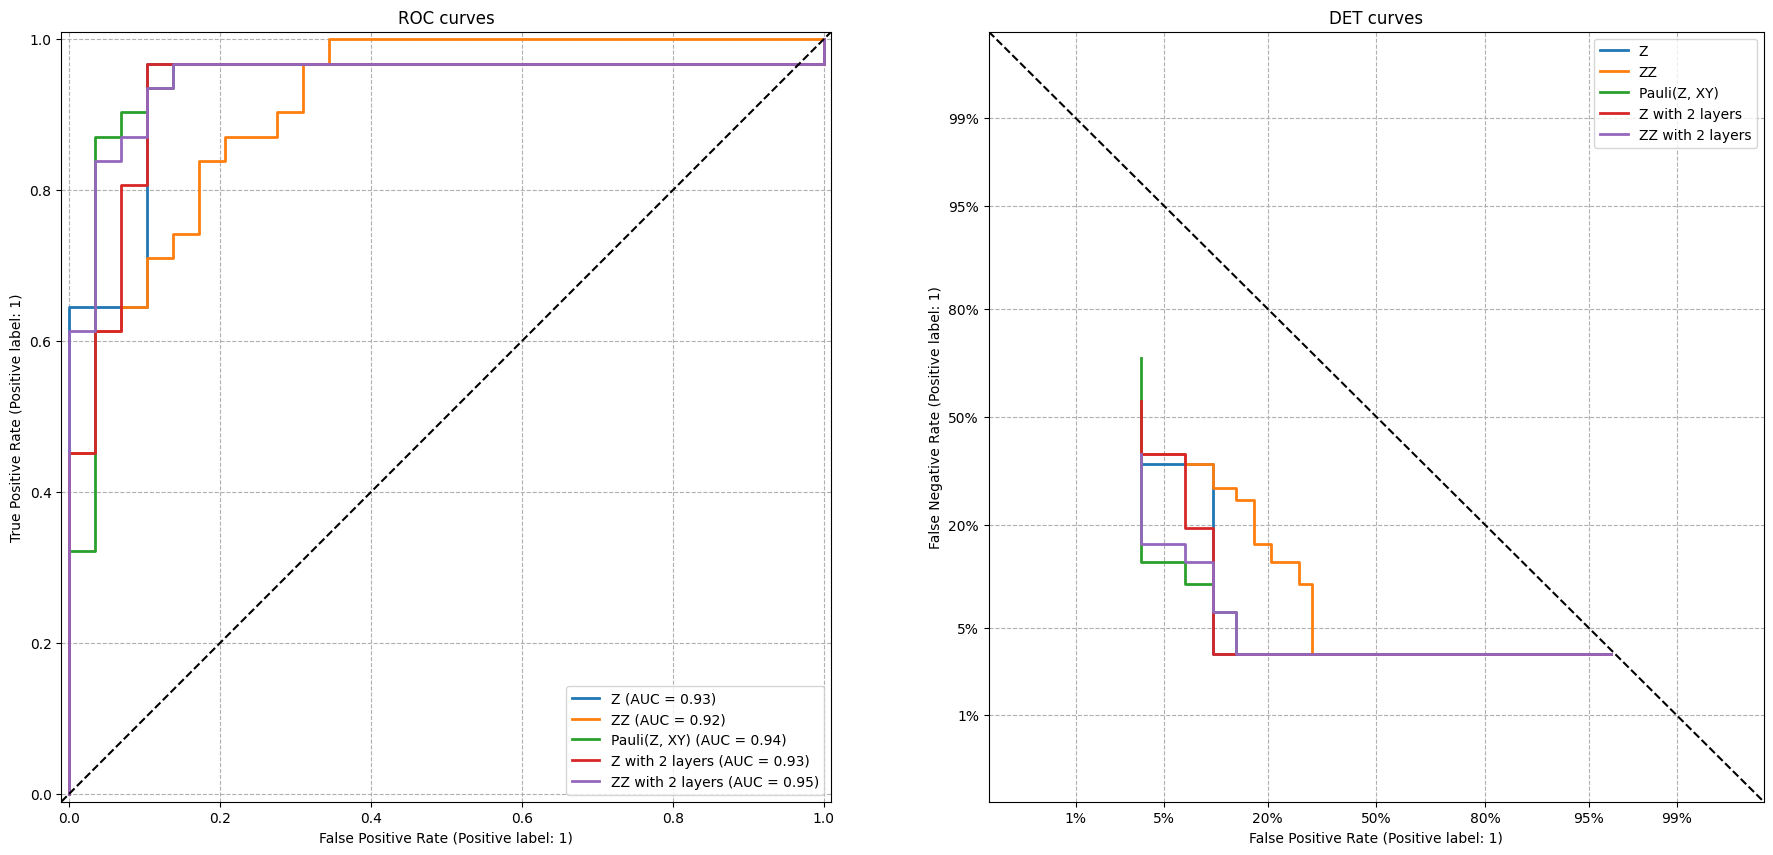

In [107]:
from sklearn.metrics import roc_curve, roc_auc_score, DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize = (22, 10))

for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train.values)
    RocCurveDisplay.from_estimator(qsvc, X_test, y_test.values, ax = ax_roc, name = feature_map_name, lw = 2)
    DetCurveDisplay.from_estimator(qsvc, X_test, y_test.values, ax = ax_det, name = feature_map_name, lw = 2)

ax_roc.set_title("ROC curves")
ax_det.set_title("DET curves")
ax_roc.grid(linestyle = "--")
ax_det.grid(linestyle = "--")
ax_roc.axline((0, 0), slope = 1, color = 'k', linestyle = '--')
ax_det.axline((0, 0), slope = -1, color = 'k', linestyle = '--')

plt.legend()
plt.show()

Now we can can change the ansatz with more complex circuits and more parameters, and test it for all the feature maps

In [41]:
# create the feature maps
Z = ZFeatureMap(feature_dimension = num_features, reps = 1)
ZZ = ZZFeatureMap(feature_dimension = num_features, reps = 1)
P = PauliFeatureMap(feature_dimension = num_features, reps = 1, paulis = ['Z', 'XY'])
Z2 = ZFeatureMap(feature_dimension = num_features, reps = 2)
ZZ2 = ZZFeatureMap(feature_dimension = num_features, reps = 2)

# Create a parametrized layer to train. We can rotate each qubit the same amount, or different amount.
training_params = ParameterVector("θ", num_features)
ansatz_layer = QuantumCircuit(num_features)
for i in range(num_features):
    ansatz_layer.ry(training_params[i], i)

# Create the trainable feature maps, composed of two circuits: the ansatz and the previous feature map
Z_param   = ansatz_layer.compose(Z)
ZZ_param  = ansatz_layer.compose(ZZ)
P_param   = ansatz_layer.compose(P)
Z2_param  = ansatz_layer.compose(Z2)
ZZ2_param = ansatz_layer.compose(ZZ2)

parametric_feature_map_dict = {'Z': Z_param, 'ZZ': ZZ_param, 'Pauli(Z, XY)': P_param, 'Z with 2 layers': Z2_param, 'ZZ with 2 layers': ZZ2_param}

print(circuit_drawer(ZZ_param))
print(f"Trainable parameters: {training_params}")

     ┌──────────┐┌────────────────────────────────────┐
q_0: ┤ Ry(θ[0]) ├┤0                                   ├
     ├──────────┤│                                    │
q_1: ┤ Ry(θ[1]) ├┤1                                   ├
     ├──────────┤│  ZZFeatureMap(x[0],x[1],x[2],x[3]) │
q_2: ┤ Ry(θ[2]) ├┤2                                   ├
     ├──────────┤│                                    │
q_3: ┤ Ry(θ[3]) ├┤3                                   ├
     └──────────┘└────────────────────────────────────┘
Trainable parameters: θ, ['θ[0]', 'θ[1]', 'θ[2]', 'θ[3]']


In [42]:
# to run on ibm quntum, import the Sampler class from IBM Qiskit Runtime, not Qiskit
#service = IBMR.QiskitRuntimeService()#channel = "ibm_quantum")#, token = "88eeb7f45dcf7770dc57b658d3a7777feba57f28d40e8790d737aea341704a16da5e7163756b82a020919f20b6ccf8c300efed8abb45b2a5a531dcbc7253e51f")
#backend = service.get_backend("ibmq_qasm_simulator")
# Set options to (eventually to include noise models)
#options = IBMR.Options()
#options.execution.shots = 1000
#options.optimization_level = 3
#options.resilience_level = 0
#sampler = IBMR.Sampler(backend = backend)

# to run locally, instantiate the Sampler class from qiskit or qiskit.Aer
sampler = Sampler()
fidelity = ComputeUncompute(sampler = sampler)

optimized_kernels = {}
callback_data = []
qkt_callback = QKTCallback()
optimizer = SPSA(maxiter = 50, callback = qkt_callback.callback, learning_rate = 0.05, perturbation = 0.05)

for feature_map_name, feature_map in parametric_feature_map_dict.items():
    quantum_kernel = TrainableFidelityQuantumKernel(fidelity = fidelity, feature_map = feature_map, training_parameters = training_params)
    qkt = QuantumKernelTrainer(quantum_kernel = quantum_kernel, loss = "svc_loss", optimizer = optimizer)
    # Train the kernel
    qkt_results = qkt.fit(X_train, y_train.values)
    #optimized_kernel = qkt_results.quantum_kernel
    #optimized_kernels.append(optimized_kernel)
    optimized_kernels[feature_map_name] = qkt_results.quantum_kernel
    callback_data.append(qkt_callback.get_callback_data())
    qkt_callback.clear_callback_data()

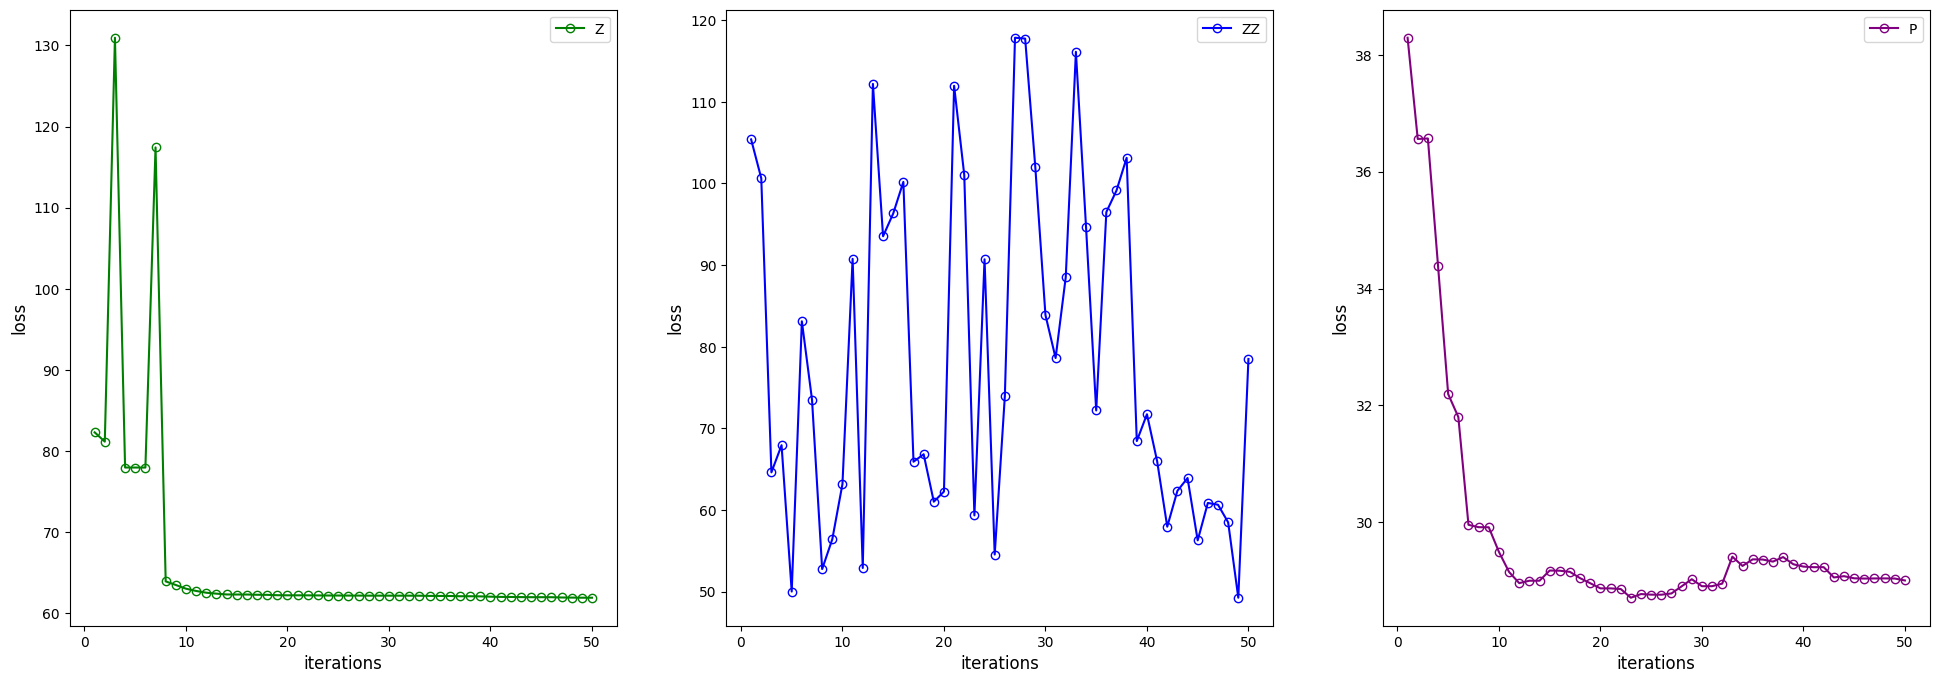

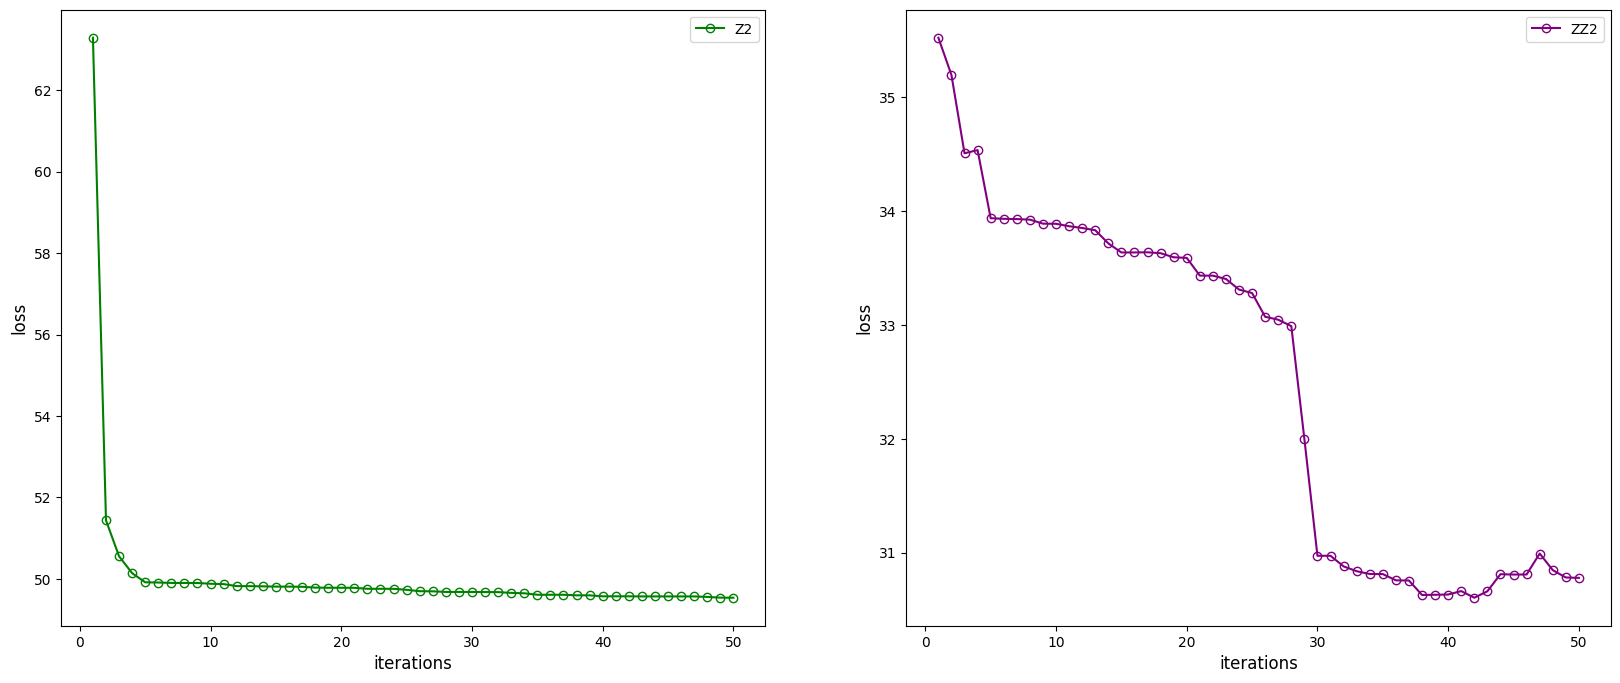

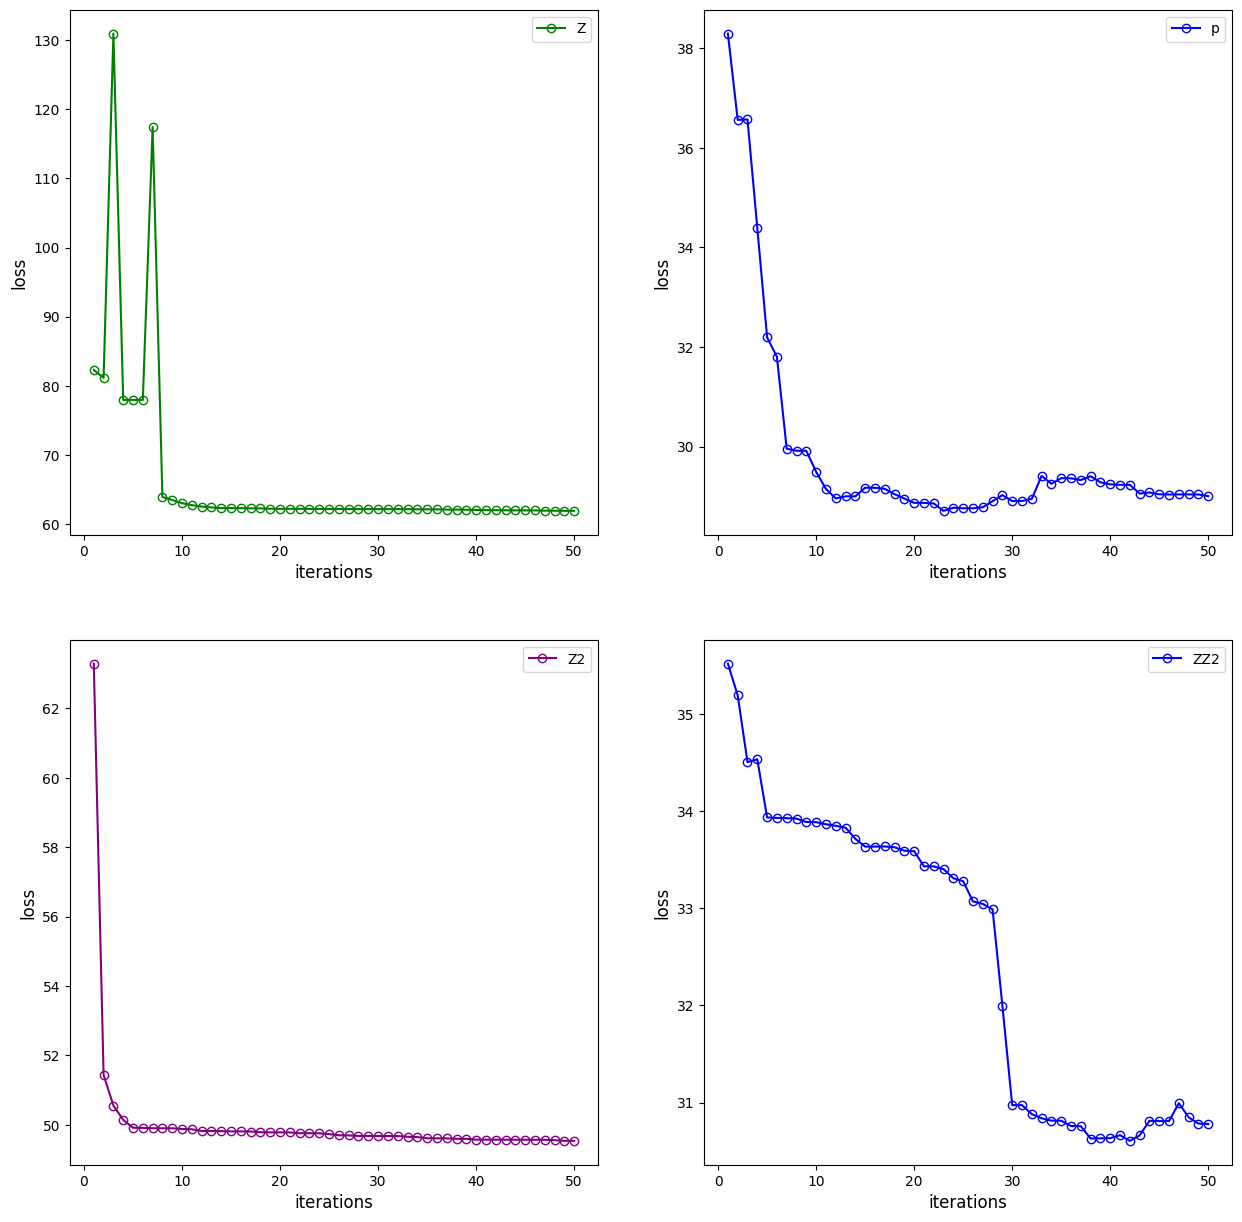

In [51]:
# visualize the training process for all the feature maps

#matplotlib.rcdefaults() 
fig = plt.figure(figsize=(24,8))
plt.subplot(131)
plt.plot([i + 1 for i in range(len(callback_data[0][0]))], np.array(callback_data[0][2]), marker = 'o', mfc = 'none', color = 'green', label = 'Z')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(132)
plt.plot([i + 1 for i in range(len(callback_data[1][0]))], np.array(callback_data[1][2]), marker = 'o', mfc = 'none', color = 'blue', label = 'ZZ')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(133)
plt.plot([i + 1 for i in range(len(callback_data[2][0]))], np.array(callback_data[2][2]), marker = 'o', mfc = 'none', color = 'purple', label = 'P')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.show()

fig = plt.figure(figsize=(20,8))
plt.subplot(121)
plt.plot([i + 1 for i in range(len(callback_data[3][0]))], np.array(callback_data[3][2]), marker = 'o', mfc = 'none', label = 'Z2', color = 'green')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(122)
plt.plot([i + 1 for i in range(len(callback_data[4][0]))], np.array(callback_data[4][2]), marker = 'o', mfc = 'none', label = 'ZZ2', color = 'purple')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.show()

fig = plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.plot([i + 1 for i in range(len(callback_data[0][0]))], np.array(callback_data[0][2]), marker = 'o', mfc = 'none', color = 'green', label = 'Z')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(222)
plt.plot([i + 1 for i in range(len(callback_data[2][0]))], np.array(callback_data[2][2]), marker = 'o', mfc = 'none', color = 'blue', label = 'P')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(223)
plt.plot([i + 1 for i in range(len(callback_data[3][0]))], np.array(callback_data[3][2]), marker = 'o', mfc = 'none', color = 'purple', label = 'Z2')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(224)
plt.plot([i + 1 for i in range(len(callback_data[4][0]))], np.array(callback_data[4][2]), marker = 'o', mfc = 'none', color = 'blue', label = 'ZZ2')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.show()

In [45]:
for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train.values)
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    # Perform predictions and evaluate performance metrics
    evaluate_with_feature_map(qsvc, X_train, y_train.values, X_test, y_test.values, feature_map_name)

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.85      0.89      0.87        71
           1       0.88      0.84      0.86        69

    accuracy                           0.86       140
   macro avg       0.87      0.86      0.86       140
weighted avg       0.86      0.86      0.86       140

Confusion Matrix for Train Set:
[[63  8]
 [11 58]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.87      0.89        31

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60

Confusion Matrix for Test Set:
[[26  3]
 [ 4 27]]
ROC AUC Score for Z Feature Map (Test Set):
0.8838
Evaluating performance for ZZ Feature Map:

now try with RealAmplitueds quantum circuit as parametric ansatz

Trainable parameters: ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11])])


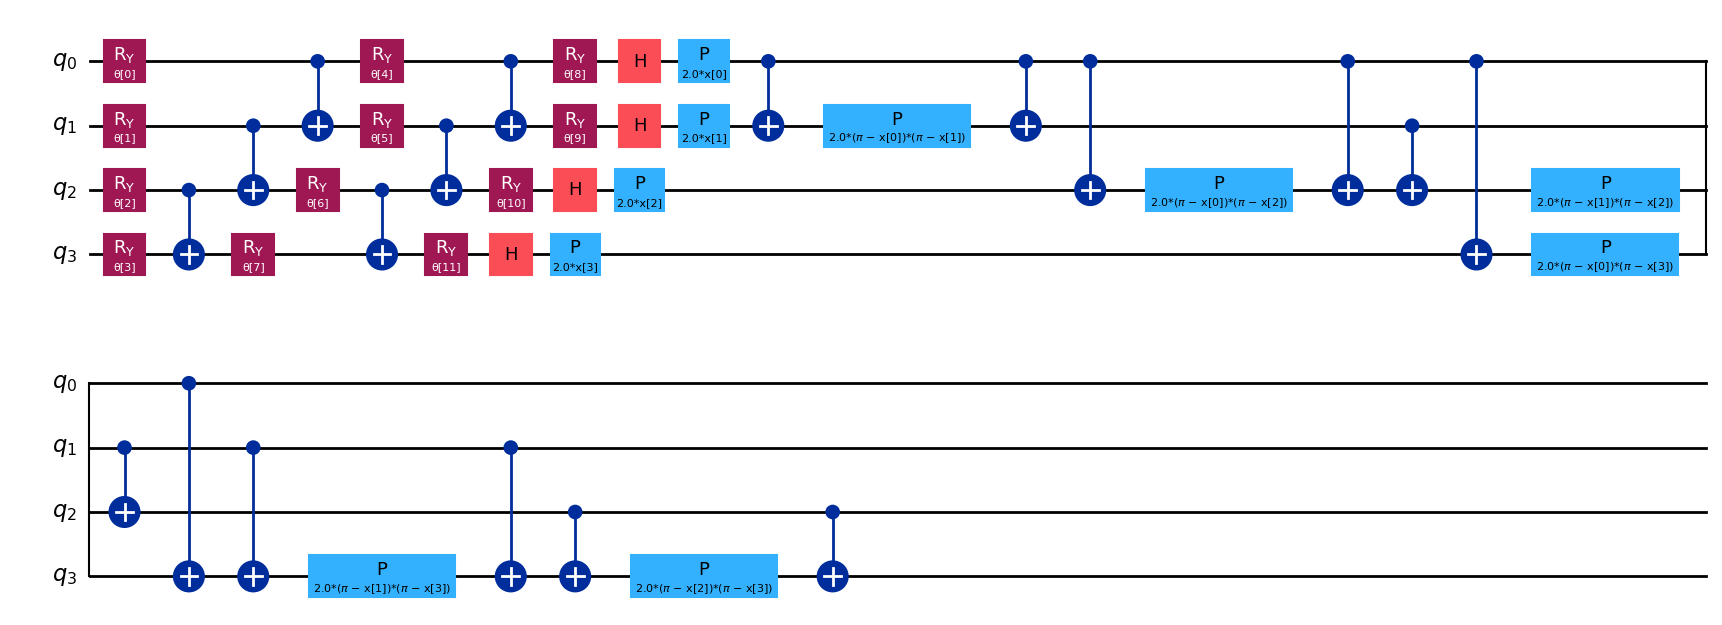

In [53]:
# create the feature maps
Z = ZFeatureMap(feature_dimension = num_features, reps = 1)
ZZ = ZZFeatureMap(feature_dimension = num_features, reps = 1)
P = PauliFeatureMap(feature_dimension = num_features, reps = 1, paulis = ['Z', 'XY'])
Z2 = ZFeatureMap(feature_dimension = num_features, reps = 2)
ZZ2 = ZZFeatureMap(feature_dimension = num_features, reps = 2)

# real amplitued parametrized ansatz
ansatz_layer = RealAmplitudes(num_qubits = num_features, reps = 2, parameter_prefix = "θ")
training_params = ansatz_layer.parameters
# Create the trainable feature maps, composed of two circuits: the ansatz and the previous feature map
Z_param   = ansatz_layer.compose(Z)
ZZ_param  = ansatz_layer.compose(ZZ)
P_param   = ansatz_layer.compose(P)
Z2_param  = ansatz_layer.compose(Z2)
ZZ2_param = ansatz_layer.compose(ZZ2)

parametric_feature_map_dict = {'Z': Z_param, 'ZZ': ZZ_param, 'Pauli(Z, XY)': P_param, 'Z with 2 layers': Z2_param, 'ZZ with 2 layers': ZZ2_param}

#print(circuit_drawer(ansatz_layer.decompose()))
print(f"Trainable parameters: {training_params}")
ZZ_param.decompose().draw(output='mpl')

In [54]:
# local run
sampler = Sampler()
fidelity = ComputeUncompute(sampler = sampler)

optimized_kernels = {}
callback_data = []
qkt_callback = QKTCallback()
optimizer = SPSA(maxiter = 20, callback = qkt_callback.callback, learning_rate = 0.05, perturbation = 0.05)
#optimizer = COBYLA(maxiter = 20)

for feature_map_name, feature_map in parametric_feature_map_dict.items():
    quantum_kernel = TrainableFidelityQuantumKernel(fidelity = fidelity, feature_map = feature_map, training_parameters = training_params)
    qkt = QuantumKernelTrainer(
        quantum_kernel = quantum_kernel, loss = "svc_loss", optimizer = optimizer
    )
    # Train the kernel
    qkt_results = qkt.fit(X_train, y_train.values)
    optimized_kernels[feature_map_name] = qkt_results.quantum_kernel
    callback_data.append(qkt_callback.get_callback_data())
    qkt_callback.clear_callback_data()

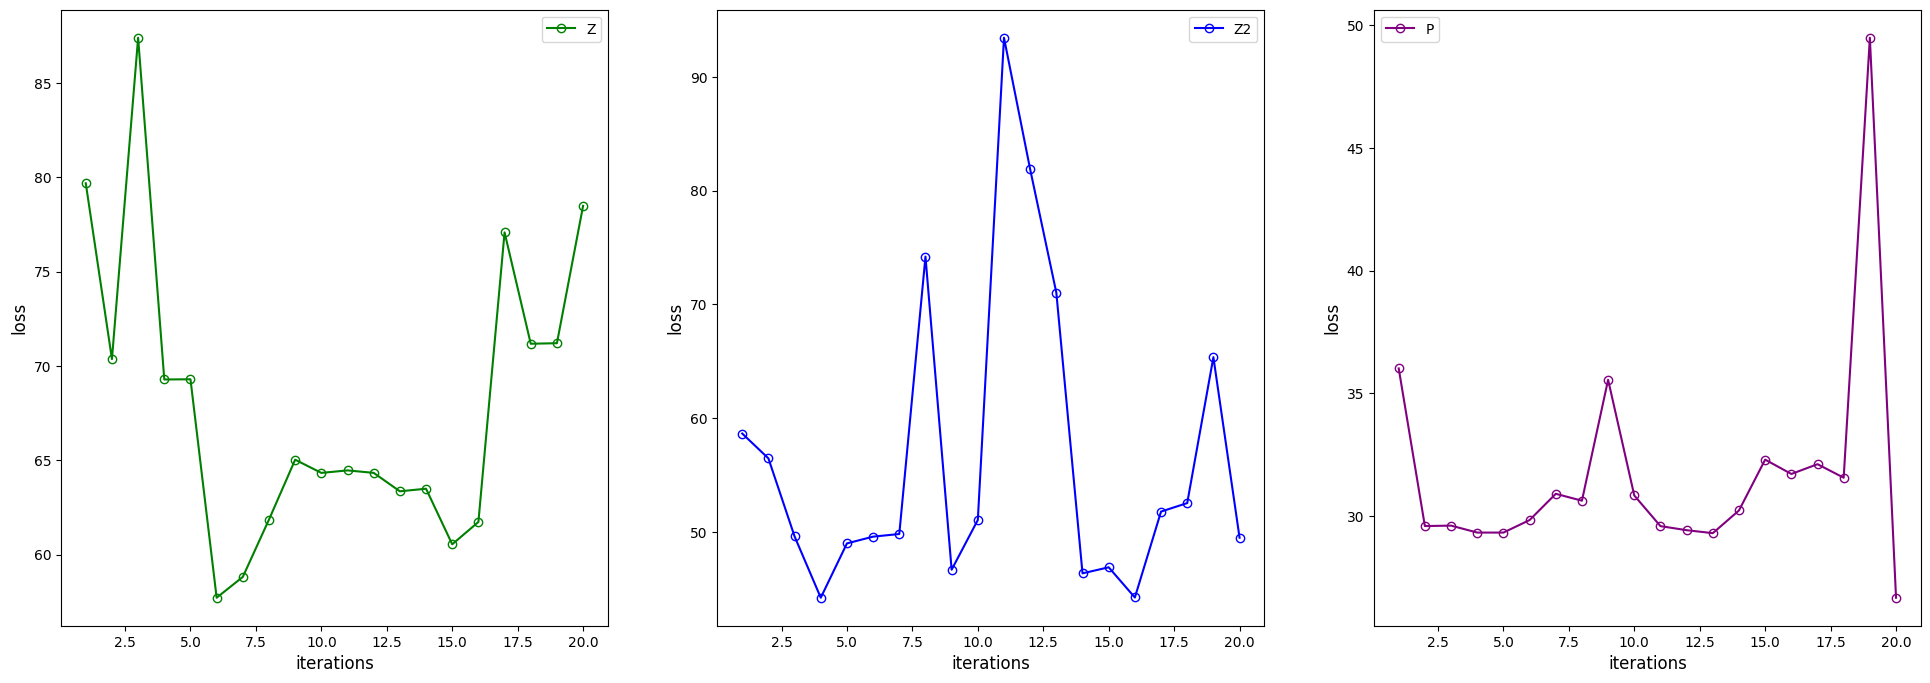

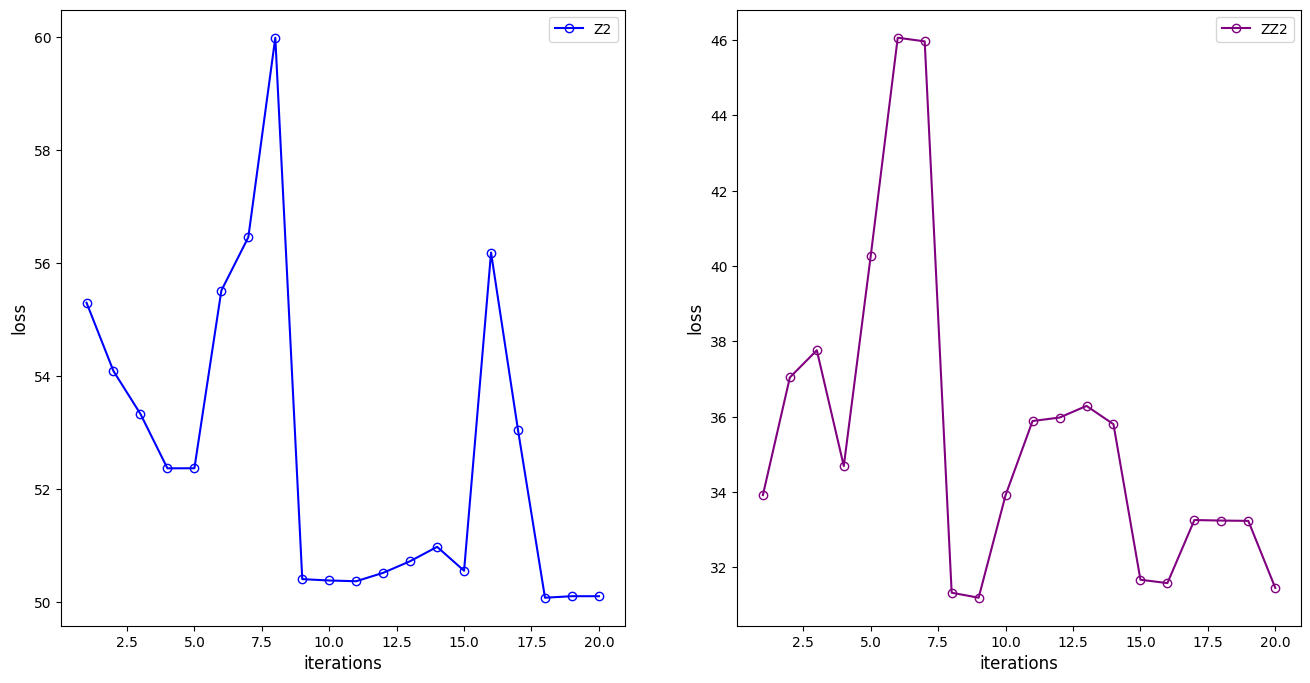

In [59]:
# visualize the training process for all the feature maps

#matplotlib.rcdefaults() 
fig = plt.figure(figsize=(24,8))
plt.subplot(131)
plt.plot([i + 1 for i in range(len(callback_data[0][0]))], np.array(callback_data[0][2]), marker = 'o', mfc = 'none', color = 'green', label = 'Z')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(132)
plt.plot([i + 1 for i in range(len(callback_data[1][0]))], np.array(callback_data[1][2]), marker = 'o', mfc = 'none', color = 'blue', label = 'ZZ')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(133)
plt.plot([i + 1 for i in range(len(callback_data[2][0]))], np.array(callback_data[2][2]), marker = 'o', mfc = 'none', color = 'purple', label = 'P')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.show()

fig = plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot([i + 1 for i in range(len(callback_data[3][0]))], np.array(callback_data[3][2]), marker = 'o', mfc = 'none', color = 'blue', label = 'Z2')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(122)
plt.plot([i + 1 for i in range(len(callback_data[4][0]))], np.array(callback_data[4][2]), marker = 'o', mfc = 'none', color = 'purple', label = 'ZZ2')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()

In [60]:
for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train.values)
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    # Perform predictions and evaluate performance metrics
    evaluate_with_feature_map(qsvc, X_train, y_train.values, X_test, y_test.values, feature_map_name)

    ## Predict the labels
    #y_test_pred = qsvc.predict(X_test)
    ## Evalaute the test accuracy
    #accuracy_test = balanced_accuracy_score(y_true = y_test, y_pred = y_test_pred)
    #print(f"QSVC accuracy test: {accuracy_test}")
    #qsvc_score = qsvc.score(X_test, y_test.values)
    #print(f"QSVC classification test score: {qsvc_score}")
    #print("\n")

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.80      0.89      0.84        71
           1       0.87      0.77      0.82        69

    accuracy                           0.83       140
   macro avg       0.83      0.83      0.83       140
weighted avg       0.83      0.83      0.83       140

Confusion Matrix for Train Set:
[[63  8]
 [16 53]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.76      0.90      0.83        29
           1       0.88      0.74      0.81        31

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.83      0.82      0.82        60

Confusion Matrix for Test Set:
[[26  3]
 [ 8 23]]
ROC AUC Score for Z Feature Map (Test Set):
0.8192
Evaluating performance for ZZ Feature Map:

### Noise model

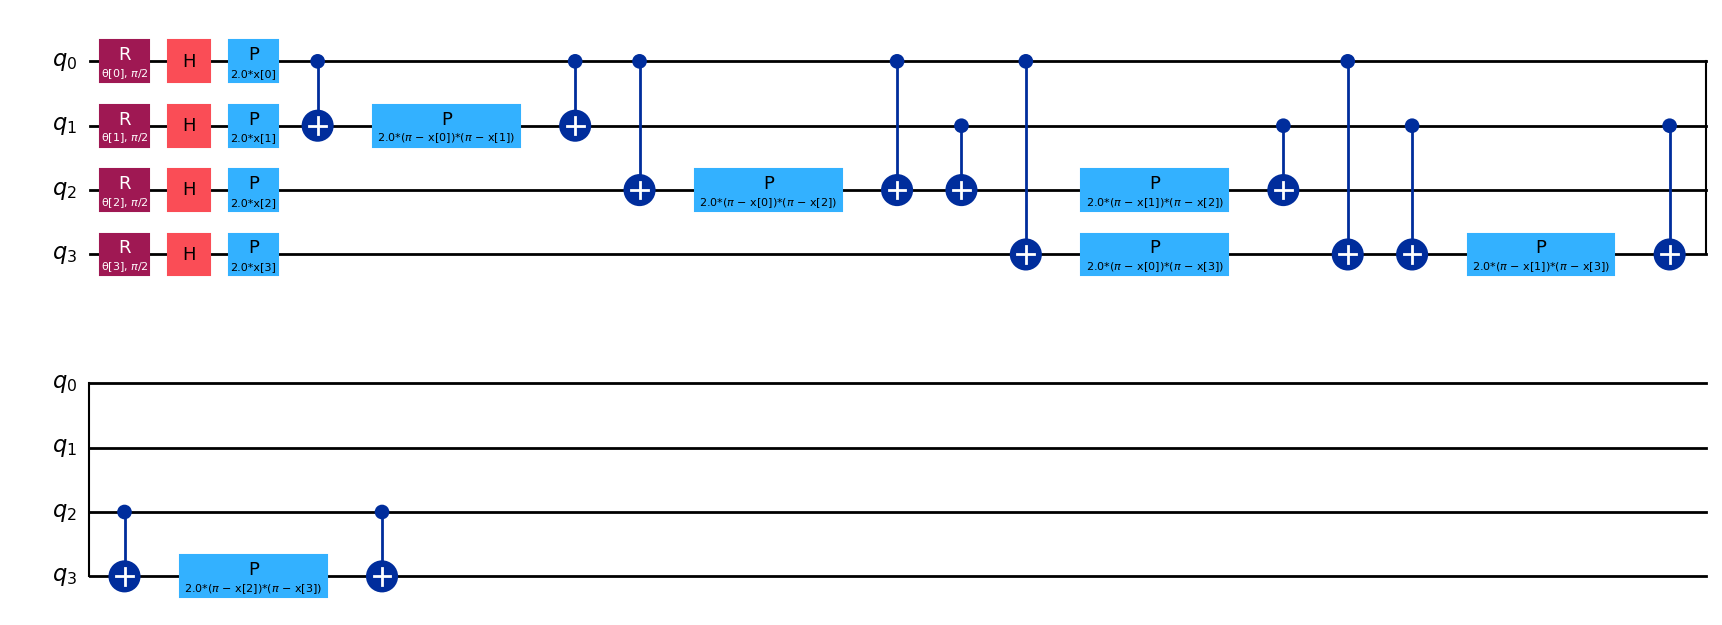

In [66]:
# create the feature maps
Z = ZFeatureMap(feature_dimension = num_features, reps = 1)
ZZ = ZZFeatureMap(feature_dimension = num_features, reps = 1)
P = PauliFeatureMap(feature_dimension = num_features, reps = 1, paulis = ['Z', 'XY'])
Z2 = ZFeatureMap(feature_dimension = num_features, reps = 2)
ZZ2 = ZZFeatureMap(feature_dimension = num_features, reps = 2)
# Create a parametrized layer to train
training_params = ParameterVector("θ", num_features)
ansatz_layer = QuantumCircuit(num_features)
for i in range(num_features):
    ansatz_layer.ry(training_params[i], i)
# Create the trainable feature maps, composed of two circuits: the ansatz and the previous feature map
Z_param   = ansatz_layer.compose(Z)
ZZ_param  = ansatz_layer.compose(ZZ)
P_param   = ansatz_layer.compose(P)
Z2_param  = ansatz_layer.compose(Z2)
ZZ2_param = ansatz_layer.compose(ZZ2)

parametric_feature_map_dict = {'Z': Z_param, 'ZZ': ZZ_param, 'Pauli(Z, XY)': P_param, 'Z with 2 layers': Z2_param, 'ZZ with 2 layers': ZZ2_param}

#print(circuit_drawer(ansatz_layer.decompose()))
#print(f"Trainable parameters: {training_params}")
ZZ_param.decompose().draw(output='mpl')

In [68]:
from qiskit.providers.fake_provider import Fake20QV1
from qiskit_aer.noise import NoiseModel

#service = IBMR.QiskitRuntimeService(channel = "ibm_quantum")#, token = "88eeb7f45dcf7770dc57b658d3a7777feba57f28d40e8790d737aea341704a16da5e7163756b82a020919f20b6ccf8c300efed8abb45b2a5a531dcbc7253e51f")
#backend = service.get_backend("ibmq_qasm_simulator")
# set the fake backend
fake_backend = Fake20QV1()
noise_model = NoiseModel.from_backend(fake_backend)
# set the options to include the noise model, the optimization level and the resilience level
#options = IBMR.Options()
options = Options()

options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}
#options.execution.shots = 1000
options.optimization_level = 3
options.resilience_level = 1

#sampler = IBMR.Sampler(options = options)
sampler = Sampler(options = options)

optimized_kernels = {}
callback_data = []

# run the model with noise:
#with IBMR.Session(service = service, backend = backend):
#sampler = IBMR.Sampler(options = options)
fidelity = ComputeUncompute(sampler = sampler)

qkt_callback = QKTCallback()
optimizer = SPSA(maxiter = 20, callback = qkt_callback.callback, learning_rate = 0.05, perturbation = 0.05)
#optimizer = COBYLA(maxiter = 20)

for feature_map_name, feature_map in parametric_feature_map_dict.items():
    quantum_kernel = TrainableFidelityQuantumKernel(fidelity = fidelity, feature_map = feature_map, training_parameters = training_params)
    qkt = QuantumKernelTrainer( quantum_kernel = quantum_kernel, loss = "svc_loss", optimizer = optimizer)
    # Train the kernel
    qkt_results = qkt.fit(X_train, y_train.values)
    optimized_kernels[feature_map_name] = qkt_results.quantum_kernel
    callback_data.append(qkt_callback.get_callback_data())
    qkt_callback.clear_callback_data()

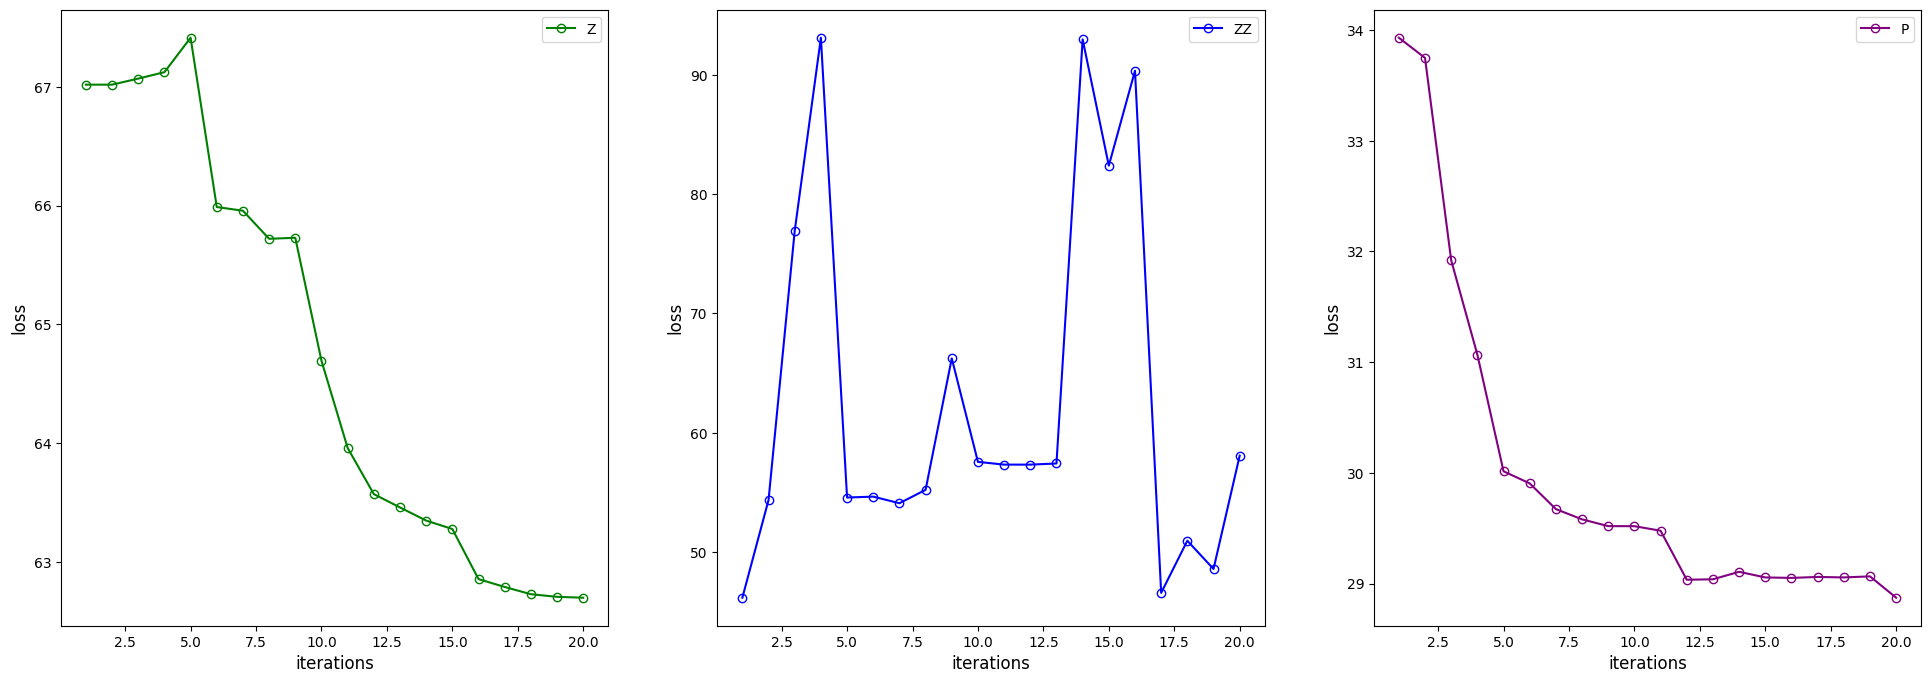

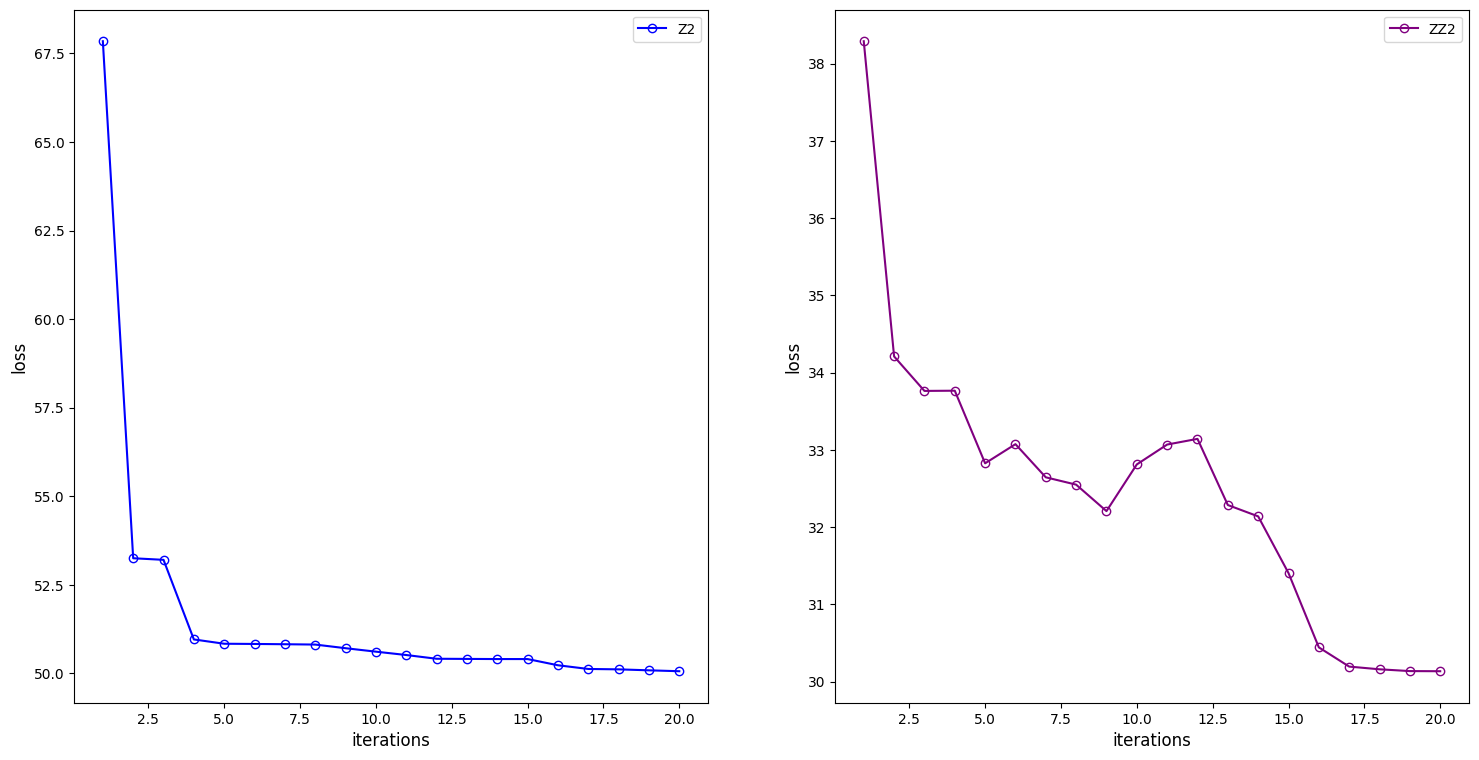

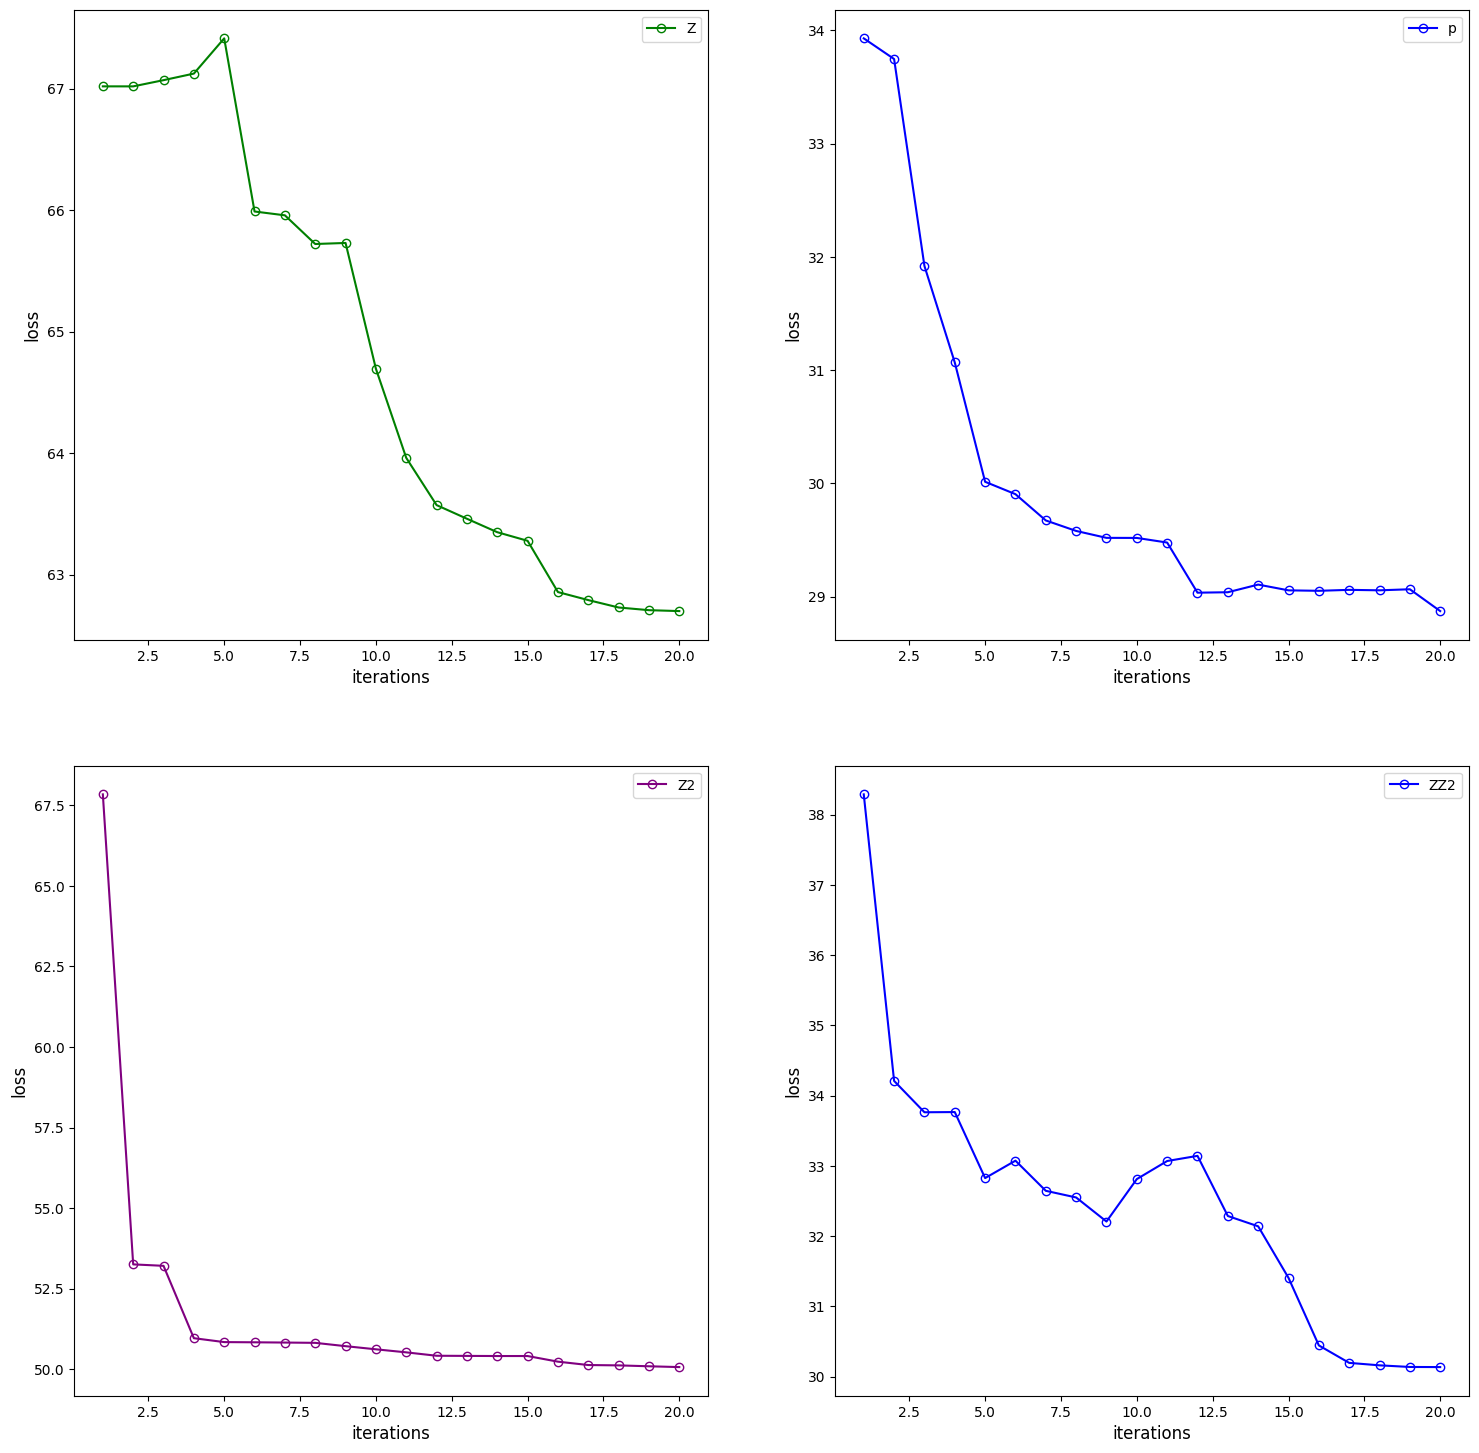

In [98]:
fig = plt.figure(figsize=(24,8))
plt.subplot(131)
plt.plot([i + 1 for i in range(len(callback_data[0][0]))], np.array(callback_data[0][2]), marker = 'o', mfc = 'none', color = 'green', label = 'Z')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(132)
plt.plot([i + 1 for i in range(len(callback_data[1][0]))], np.array(callback_data[1][2]), marker = 'o', mfc = 'none', color = 'blue', label = 'ZZ')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(133)
plt.plot([i + 1 for i in range(len(callback_data[2][0]))], np.array(callback_data[2][2]), marker = 'o', mfc = 'none', color = 'purple', label = 'P')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.show()

fig = plt.figure(figsize=(18,9))
plt.subplot(121)
plt.plot([i + 1 for i in range(len(callback_data[3][0]))], np.array(callback_data[3][2]), marker = 'o', mfc = 'none', color = 'blue', label = 'Z2')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(122)
plt.plot([i + 1 for i in range(len(callback_data[4][0]))], np.array(callback_data[4][2]), marker = 'o', mfc = 'none', color = 'purple', label = 'ZZ2')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()

fig = plt.figure(figsize=(18, 18))
plt.subplot(221)
plt.plot([i + 1 for i in range(len(callback_data[0][0]))], np.array(callback_data[0][2]), marker = 'o', mfc = 'none', color = 'green', label = 'Z')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(222)
plt.plot([i + 1 for i in range(len(callback_data[2][0]))], np.array(callback_data[2][2]), marker = 'o', mfc = 'none', color = 'blue', label = 'P')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(223)
plt.plot([i + 1 for i in range(len(callback_data[3][0]))], np.array(callback_data[3][2]), marker = 'o', mfc = 'none', color = 'purple', label = 'Z2')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.subplot(224)
plt.plot([i + 1 for i in range(len(callback_data[4][0]))], np.array(callback_data[4][2]), marker = 'o', mfc = 'none', color = 'blue', label = 'ZZ2')
plt.xlabel("iterations", fontsize = 12)
plt.ylabel("loss", fontsize = 12)
plt.legend()
plt.show()

In [71]:
for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train.values)
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    # Perform predictions and evaluate performance metrics
    evaluate_with_feature_map(qsvc, X_train, y_train.values, X_test, y_test.values, feature_map_name)

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        71
           1       0.88      0.83      0.85        69

    accuracy                           0.86       140
   macro avg       0.86      0.86      0.86       140
weighted avg       0.86      0.86      0.86       140

Confusion Matrix for Train Set:
[[63  8]
 [12 57]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.87      0.89        31

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60

Confusion Matrix for Test Set:
[[26  3]
 [ 4 27]]
ROC AUC Score for Z Feature Map (Test Set):
0.8838
Evaluating performance for ZZ Feature Map:

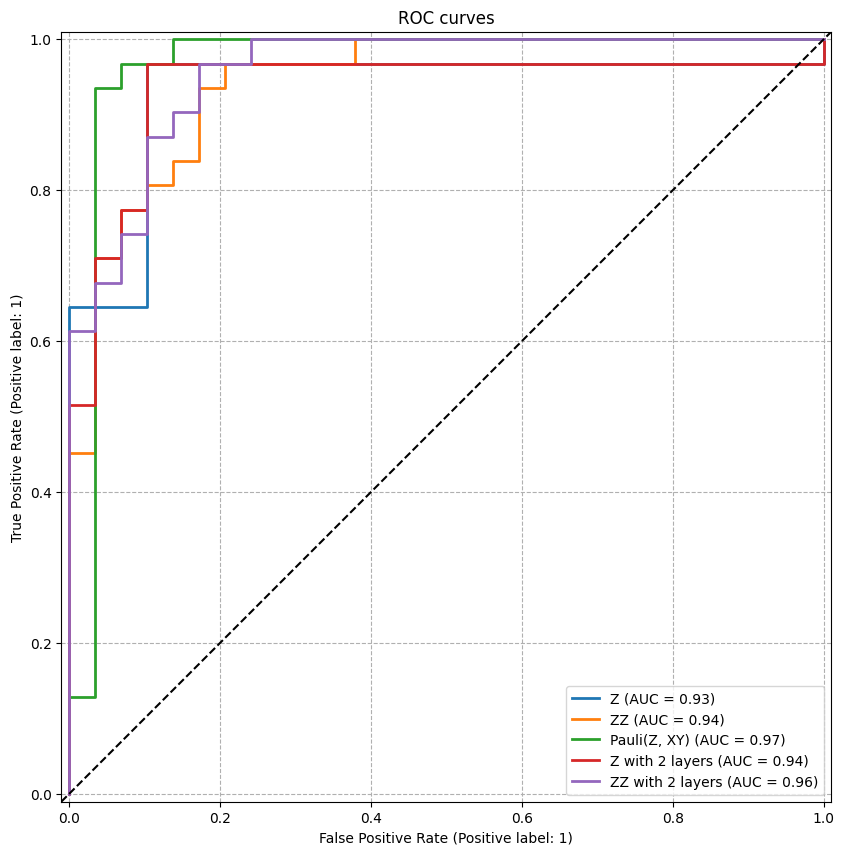

In [89]:
from sklearn.metrics import roc_curve, roc_auc_score, DetCurveDisplay, RocCurveDisplay

fig, ax_roc = plt.subplots(1, 1, figsize = (10, 10))

for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train.values)
    RocCurveDisplay.from_estimator(qsvc, X_test, y_test.values, ax = ax_roc, name = feature_map_name, lw = 2)

ax_roc.set_title("ROC curves")
ax_roc.grid(linestyle = "--")
ax_roc.axline((0, 0), slope = 1, color = 'k', linestyle = '--')

plt.legend()
plt.show()

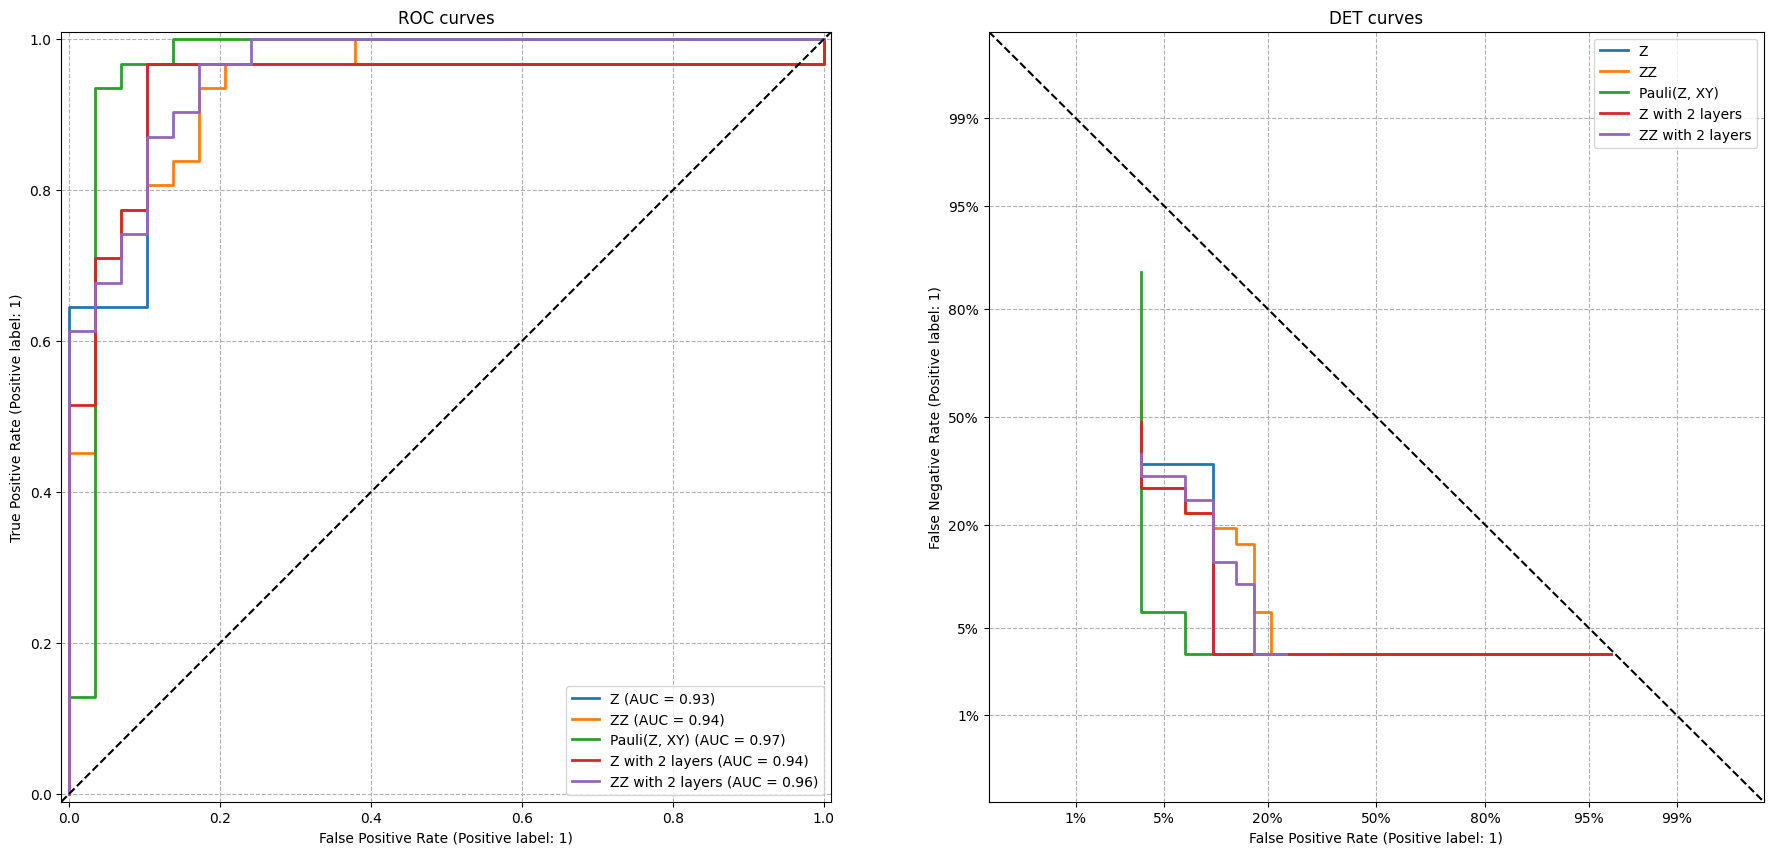

In [90]:
from sklearn.metrics import roc_curve, roc_auc_score, DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize = (22, 10))

for feature_map_name, optimized_kernel in optimized_kernels.items():
    qsvc = QSVC(quantum_kernel = optimized_kernel)
    # Fit the QSVC
    qsvc.fit(X_train, y_train.values)
    RocCurveDisplay.from_estimator(qsvc, X_test, y_test.values, ax = ax_roc, name = feature_map_name, lw = 2)
    DetCurveDisplay.from_estimator(qsvc, X_test, y_test.values, ax = ax_det, name = feature_map_name, lw = 2)

ax_roc.set_title("ROC curves")
ax_det.set_title("DET curves")
ax_roc.grid(linestyle = "--")
ax_det.grid(linestyle = "--")
ax_roc.axline((0, 0), slope = 1, color = 'k', linestyle = '--')
ax_det.axline((0, 0), slope = -1, color = 'k', linestyle = '--')

plt.legend()
plt.show()

### Quantum kernel methods for principal component analysis

In [235]:
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression

In [236]:
# initialize the sampler and the fidelity parameter for the quantum kernel
sampler = Sampler()
fidelity = ComputeUncompute(sampler = sampler)

# initialize the feature map and the quantum kernel
# in this case we use only two features
ZZ2 = ZZFeatureMap(feature_dimension = 2, reps = 2)
#P = PauliFeatureMap(feature_dimension = num_features, reps = 1, paulis = ['Z', 'XY'])
quantum_pca_kernel = FidelityQuantumKernel(fidelity = fidelity, feature_map = ZZ2)

# evaluate kernel matrices for the training and test features
quantum_matrix_train = quantum_pca_kernel.evaluate(x_vec = X_train[:, 2:4])
quantum_matrix_test  = quantum_pca_kernel.evaluate(x_vec = X_test[:, 2:4], y_vec = X_train[:, 2:4])

In [237]:
# compute a gaussian classical kernel and transform the feature according
classic_kernel_pca_rbf = KernelPCA(n_components = 2, kernel = "poly")
classic_kernel_pca_rbf.fit(X_train[:, 2:4])
X_train_rbf = classic_kernel_pca_rbf.transform(X_train[:, 2:4])
X_test_rbf  = classic_kernel_pca_rbf.transform(X_test[:, 2:4])

# compute a quantum kernel and transform the feature according
quantum_kernel_pca = KernelPCA(n_components = 2, kernel = "precomputed")
X_train_quantum = quantum_kernel_pca.fit_transform(quantum_matrix_train)
X_test_quantum  = quantum_kernel_pca.transform(quantum_matrix_test)

# train and score a classical model using the transformed features
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_rbf, y_train)
logistic_score = logistic_regression.score(X_test_rbf, y_test)
print(f"Logistic regression score: {logistic_score}")

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_quantum, y_train)
logistic_score = logistic_regression.score(X_test_quantum, y_test)
print(f"Logistic regression score: {logistic_score}")

Logistic regression score: 0.8666666666666667
Logistic regression score: 0.9


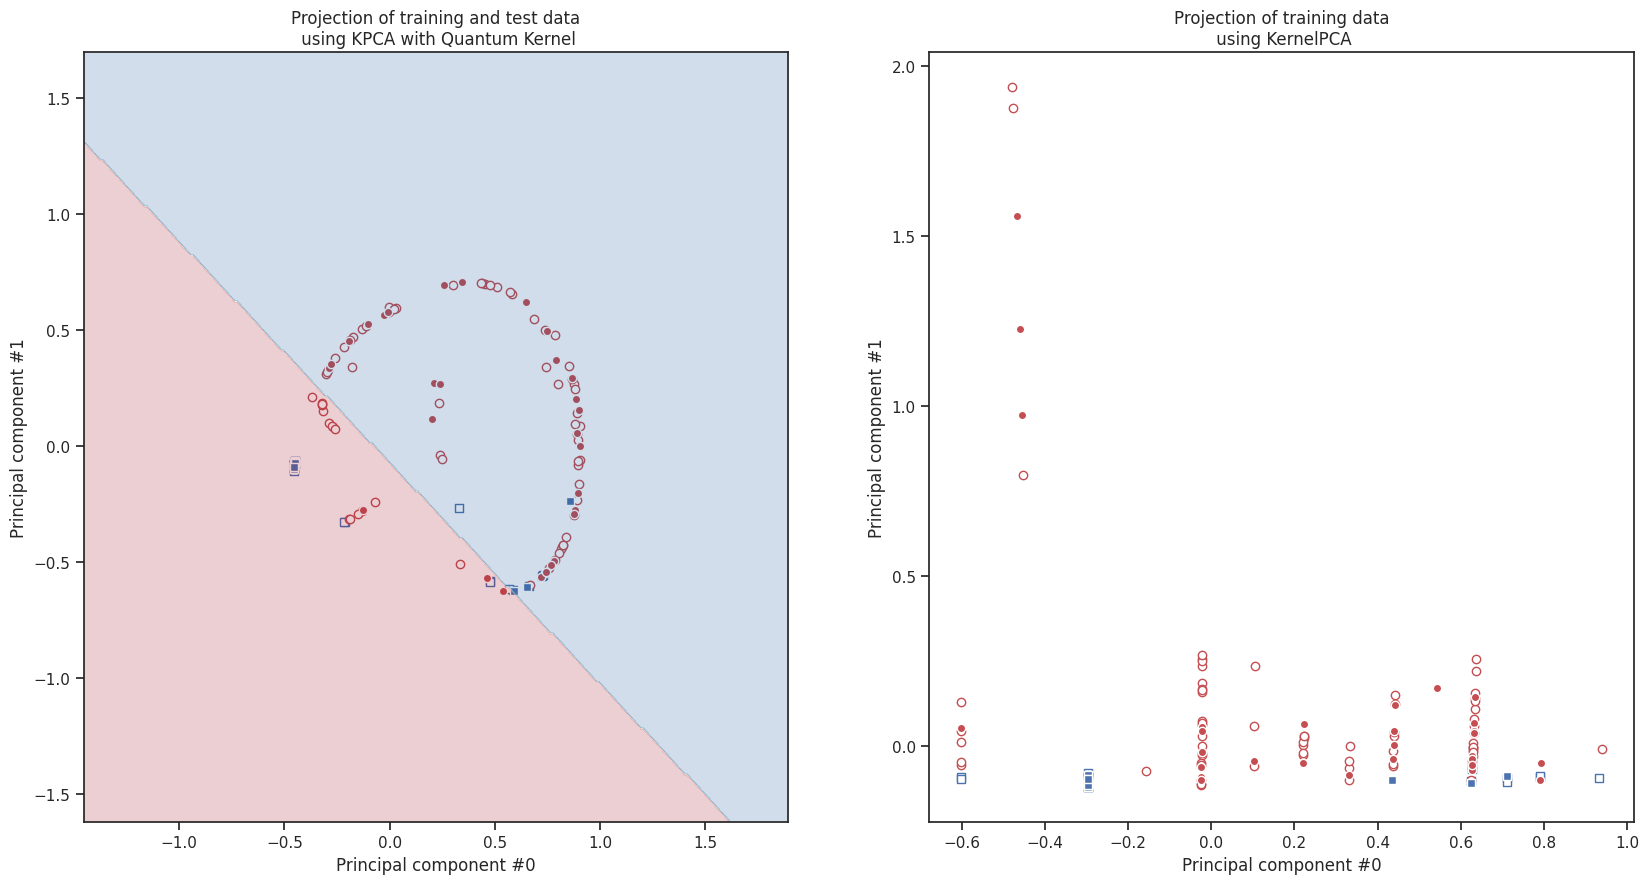

In [238]:
fig, (quantum_ax, rbf_ax) = plt.subplots(1, 2, figsize=(20, 10))


plot_features(quantum_ax, X_train_quantum, y_train, 0, "s", "w", "b", "A train")
plot_features(quantum_ax, X_train_quantum, y_train, 1, "o", "w", "r", "B train")

plot_features(quantum_ax, X_test_quantum,  y_test,  0, "s", "b", "w", "A test")
plot_features(quantum_ax, X_test_quantum,  y_test,  1, "o", "r", "w", "B test")

quantum_ax.set_ylabel("Principal component #1")
quantum_ax.set_xlabel("Principal component #0")
quantum_ax.set_title("Projection of training and test data\n using KPCA with Quantum Kernel")

# Plotting the linear separation
h = 0.01  # step size in the mesh

# create a mesh to plot in
x_min, x_max = X_train_quantum[:, 0].min() - 1, X_train_quantum[:, 0].max() + 1
y_min, y_max = X_train_quantum[:, 1].min() - 1, X_train_quantum[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

predictions = logistic_regression.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
predictions = predictions.reshape(xx.shape)
quantum_ax.contourf(xx, yy, predictions, cmap = plt.cm.RdBu, alpha = 0.2)

plot_features(rbf_ax, X_train_rbf, y_train, 0, "s", "w", "b", "A train")
plot_features(rbf_ax, X_train_rbf, y_train, 1, "o", "w", "r", "B train")
plot_features(rbf_ax, X_test_rbf , y_test , 0, "s", "b", "w", "A test")
plot_features(rbf_ax, X_test_rbf , y_test , 1, "o", "r", "w", "A test")

rbf_ax.set_ylabel("Principal component #1")
rbf_ax.set_xlabel("Principal component #0")
rbf_ax.set_title("Projection of training data\n using KernelPCA")
plt.show()

Then we can use the QuASK software to analyze the quantum advantage